<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/OB1%EC%A1%B0_%EB%B0%A9%ED%95%99%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EB%B3%B4%EA%B3%A0%EC%84%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OB 1조 프로젝트 [도서-음악 추천 시스템]

# 1) 데이터 수집

In [ ]:
import numpy as np
import pandas as pd

## **도서 데이터 크롤링**

In [ ]:
# 전체 베스트셀러 파일 불러오기
df_all = pd.read_excel('/content/교보문고_베스트셀러_전체.xlsx', header=0)
df_all.head()

,순위,상품코드,판매상품 ID,상품명,정가,판매가,할인율,적립율,적립예정포인트,인물,출판사,발행(출시)일자,분야
0,1,9788932916194,S000000581727,창문 넘어 도망친 100세 노인,"16,800","15,120",10%,5%,840,요나스 요나손,열린책들,20130725,소설
1,2,9788952227829,S000000721821,미 비포 유(Me Before You),"15,000","13,500",10%,5%,750,조조 모예스,살림,20140101,소설
2,3,9788993734348,S000001533409,어떤 하루,"13,800","12,420",10%,5%,690,신준모,프롬북스,20140310,시/에세이
3,4,9788970653976,S000001080137,내가 사랑한 유럽 TOP10,"15,800","14,220",10%,5%,790,정여울,홍익출판사,20140115,여행
4,5,9788937488351,S000000621210,감정수업,"19,500","17,550",10%,5%,970,강신주,민음사,20131120,인문


In [ ]:
# 중복 데이터 제거
df_unique = df_all.drop_duplicates(subset='상품명', keep='first')

- **Daum API 호출**

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.3/486.3 kB 29.4 MB/s eta 0:00:00


In [ ]:
# 라이브러리 임포트
import requests
import json

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

In [ ]:
# daum api
rest_api_key = "호출 키를 입력하세요"
url = "https://dapi.kakao.com/v3/search/book"
header = {'Authorization': 'KakaoAK '+rest_api_key}

### 크롤링 함수

In [ ]:
# 클릭 버튼(펼쳐보기) 예외 처리 함수
def safe_click(driver, xpath):
    try:
        button = driver.find_element(By.XPATH, xpath)
        button.click()
    except:
        pass  # 버튼이 없으면 그냥 넘어가도록 처리

In [ ]:
# text 예외 처리 함수
# 책소개, 책속으로, 서평 중 없는 것이 있어도 오류 없이 넘어가도록 처리
def safe_find_text(driver, xpath, default=np.nan):
    try:
        return driver.find_element(By.XPATH, xpath).text
    except NoSuchElementException:
        return default

In [ ]:
# 크롤링 함수
def book_crawling(df, num) :
  book_num = len(df)

  for i in range(num, book_num):
    isbn = df.iloc[i]['상품코드']
    book_name = df.iloc[i]['상품명']
    queryString = {'query' : isbn} # 검색하고 싶은 도서의 제목 입력

    # 도서 정보 불러오기
    response = requests.get(url, headers=header, params=queryString)
    content = response.text
    book_data = json.loads(content)['documents'][0]

    try:
      authors = book_data['authors'][0]
    except:
      authors = np.nan

    # 크롤링 시작
    target_url = book_data['url']
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # 헤드리스 모드로 실행
    chrome_options.add_argument("--disable-gpu")  # GPU 사용 안함
    chrome_options.add_argument("--no-sandbox")  # 보안 관련 문제 방지
    chrome_options.add_argument("--remote-debugging-port=9222")  # 디버깅 포트 설정

    driver = webdriver.Chrome(options=chrome_options) # 크롬 드라이버 생성
    driver.implicitly_wait(3) # 페이지 로딩 완료까지 대기(3초)
    driver.get(target_url) # 사이트 접속

    ## 책소개
    safe_click(driver, '//*[@id="tabContent"]/div[1]/div[2]/div[3]/a')
    책소개 = safe_find_text(driver, '//*[@id="tabContent"]/div[1]/div[2]/p')

    ## 책속으로
    safe_click(driver, '//*[@id="tabContent"]/div[1]/div[5]/div[3]/a')
    책속으로 = safe_find_text(driver, '//*[@id="tabContent"]/div[1]/div[5]/p')

    ## 서평
    safe_click(driver, '//*[@id="tabContent"]/div[1]/div[6]/div[3]/a')
    서평 = safe_find_text(driver, '//*[@id="tabContent"]/div[1]/div[6]/p')


    book_df.loc[i] = [book_name, authors, 책소개, 책속으로, 서평]
    print(f'{i}번째: {book_name}, 크롤링 완료')

  return book_df

### 크롤링 시작

In [ ]:
book_df = pd.DataFrame(columns=['제목', '저자', '책소개', '책속으로', '서평'])
book_crawling(df_unique)

0번째: 창문 넘어 도망친 100세 노인, 크롤링 완료
1번째: 미 비포 유(Me Before You), 크롤링 완료
2번째: 어떤 하루, 크롤링 완료
3번째: 내가 사랑한 유럽 TOP10, 크롤링 완료
4번째: 감정수업, 크롤링 완료
5번째: 에드워드 툴레인의 신기한 여행, 크롤링 완료
6번째: 여자 없는 남자들, 크롤링 완료
7번째: 나미야 잡화점의 기적, 크롤링 완료
8번째: 1cm+(일 센티 플러스), 크롤링 완료
9번째: 정글만리 1, 크롤링 완료
10번째: 장하준의 경제학 강의, 크롤링 완료
11번째: 겨울 왕국 무비 스토리북, 크롤링 완료
12번째: 꾸뻬씨의 행복여행, 크롤링 완료
13번째: 비밀의 정원, 크롤링 완료
14번째: 인생수업, 크롤링 완료
15번째: 너는 나에게 상처를 줄 수 없다, 크롤링 완료
16번째: 해커스 토익 Reading, 크롤링 완료
17번째: 그래도 사랑, 크롤링 완료
18번째: 유엔미래보고서 2040, 크롤링 완료
19번째: 1cm(일 센티) 첫 번째 이야기, 크롤링 완료
20번째: 미생: 아직 살아 있지 못한 자 1: 착수, 크롤링 완료
21번째: 내일, 크롤링 완료
22번째: 총 균 쇠, 크롤링 완료
23번째: 해커스 토익 보카(구토익), 크롤링 완료
24번째: 나의 한국현대사, 크롤링 완료
25번째: 해커스 토익 스타트 리딩(구토익), 크롤링 완료
26번째: 다윗과 골리앗, 크롤링 완료
27번째: 잡담이 능력이다(리커버), 크롤링 완료
28번째: 해커스 토익 Listening, 크롤링 완료
29번째: 나는 까칠하게 살기로 했다, 크롤링 완료
30번째: 세계 최고의 인재들은 왜 기본에 집중할까, 크롤링 완료
31번째: 제3인류 1, 크롤링 완료
32번째: 싸드(THAAD), 크롤링 완료
33번째: 나는 죽을 때까지 재미있게 살고싶다, 크롤링 완료
34번째: 겨울 왕국, 크롤링 완료
35번째: 하버드의 생각수업, 크롤링 완료
36번째: 잘못은 우리 별에 있어, 크롤링 완료
37번째: 21세기 자본, 크롤링 완료
38번

WebDriverException: Message: disconnected: Unable to receive message from renderer
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=131.0.6778.204)
Stacktrace:
#0 0x5577074718fa <unknown>
#1 0x557706f82d20 <unknown>
#2 0x557706f6aff7 <unknown>
#3 0x557706f6acce <unknown>
#4 0x557706f68d06 <unknown>
#5 0x557706f6937a <unknown>
#6 0x557706f85649 <unknown>
#7 0x5577070151b5 <unknown>
#8 0x557706ff5af2 <unknown>
#9 0x557707014560 <unknown>
#10 0x557706ff5893 <unknown>
#11 0x557706fc430d <unknown>
#12 0x557706fc532e <unknown>
#13 0x55770743e00b <unknown>
#14 0x557707441f97 <unknown>
#15 0x55770742a71c <unknown>
#16 0x557707442b17 <unknown>
#17 0x55770740f6cf <unknown>
#18 0x5577074606b8 <unknown>
#19 0x557707460880 <unknown>
#20 0x557707470776 <unknown>
#21 0x1409b08f1ac3 <unknown>


- 오류로 인해 여러 번 끊어서 크롤링 진행

In [ ]:
# 중간 부분 생략
# ...
book_crawling(df_unique, 2062)

2062번째: 쓸 만한 인간, 크롤링 완료
2063번째: 네모아저씨의 페이퍼 블레이드 디럭스, 크롤링 완료
2064번째: 소맥거핀 일상 만화 2, 크롤링 완료
2065번째: 슈뻘맨의 숨은 국어 찾기 1, 크롤링 완료
2066번째: 최애의 아이 15, 크롤링 완료
2067번째: 망그러진 만화 3, 크롤링 완료
2068번째: 더 빠르게 실패하기(15만 부 기념 에디션), 크롤링 완료
2069번째: 새들이 남쪽으로 가는 날, 크롤링 완료
2070번째: 설국, 크롤링 완료
2071번째: 타키 포오 얼렁뚱땅 상식스쿨 5, 크롤링 완료
2072번째: 멜로우 TV 2: 어쩌다 게임 오버?!, 크롤링 완료
2073번째: 존재의 역사, 크롤링 완료
2074번째: 장송의 프리렌 13, 크롤링 완료
2075번째: 스파이 패밀리 14, 크롤링 완료
2076번째: 스킵과 로퍼 9, 크롤링 완료
2077번째: 디즈니 모아나2 무비동화, 크롤링 완료
2078번째: 더 인간적인 건축, 크롤링 완료
2079번째: 나의 두 번째 교과서 X 궤도의 다시 만난 과학, 크롤링 완료
2080번째: 슈팅스타 캐치! 티니핑 빛을 나눠 줄게, 크롤링 완료
2081번째: 쓸수록 돈이 된다, 크롤링 완료
2082번째: 미국주식 처음공부, 크롤링 완료
2083번째: 런던이의 마법병원, 크롤링 완료
2084번째: 빨간내복야코 수상한 발명품 스포키의 비밀 노트 1, 크롤링 완료
2085번째: 된다! 하루 만에 끝내는 챗GPT 활용법, 크롤링 완료
2086번째: 불안 사회, 크롤링 완료
2087번째: 극락가 3, 크롤링 완료
2088번째: 초효율, 크롤링 완료
2089번째: 명화의 발견, 그때 그 사람, 크롤링 완료
2090번째: AI 2025 트렌드&활용백과, 크롤링 완료
2091번째: 경기도 부동산의 힘, 크롤링 완료
2092번째: 모든 돈의 미래 비트코인, 크롤링 완료
2093번째: 부오니시모! 나의 미뇨끼 레시피북, 크롤링 완료
2094번째: 쉼과 나아감에 대하여, 크롤링 완료
2095번째: 생각하라 그리고

,제목,저자,책소개,책속으로,서평
2062,쓸 만한 인간,박정민,배우 박정민의 《쓸 만한 인간》이 3년여 만에 개정증보판으로 돌아왔다. 영화 〈파수...,"아직도 집중 받는 걸 극히 혐오하고, 사람이 많은 공간에선 숨조차 제대로 못 쉬는 ...","자신을 위로하기 위해 쓴 글,\n응원이 필요한 모두를 위로하다\n\n“제 글은 다른..."
2063,네모아저씨의 페이퍼 블레이드 디럭스,이원표,네모아저씨의 페이퍼 블레이드》 이름의 일곱 번째 책이 출간되었습니다. 해마다 25종...,,"총 30종으로 더 오래, 더 재밌게!\n팽이는 한 시간 가까이 몰입해야 하나를 완성..."
2064,소맥거핀 일상 만화 2,NaN,출간 즉시 베스트셀러! 누구나 공감하는 주제를 아무나 따라 할 수 없는 독특한 개그...,,"해외에서도 인기 급상승 중인 애니메이션 채널, 소맥거핀\n소맥거핀은 그림 그리는 것..."
2065,슈뻘맨의 숨은 국어 찾기 1,권나혜,《슈뻘맨의 숨은 국어 찾기》는 유튜브 크리에이터 슈뻘맨의 좌충우돌 웃음 가득한 일상...,,"도전, 대결 콘텐츠를 꿀잼 영상으로 풀어 내는 ‘슈뻘맨’\n‘슈뻘맨’은 세상의 모든..."
2066,최애의 아이 15,아카사카 아카,영화 '15년의 거짓말' 촬영은 아이의 과거가 그려지는 형태로 진행 중ー.\n아쿠아...,,
2067,망그러진 만화 3,NaN,★★★★ 미공개 에피소드와 한정판 페이퍼 토이북 수록! ★★★★\n\n‘이모티콘 캐...,,"“조금 울고, 많이 웃고, 함께하기\n인생은 망그러진 곰처럼!”\n\n이 책은 크고..."
2068,더 빠르게 실패하기(15만 부 기념 에디션),존 크럼볼츠,『더 빠르게 실패하기 Fail Even Faster』는 존 크럼볼츠(John Kru...,이 프로젝트에 실제 참여한 수만 명의 개인과 이야기하면서 우리 연구팀은 중요한 발견...,"* 리뷰 2,000건 이상 4.5/5 평점 기록(Amazon 기준)\n* 스탠퍼드대..."
2069,새들이 남쪽으로 가는 날,리사 리드젠,"2024 스웨덴 올해의 도서상 수상, 스웨덴 덴마크 베스트셀러 1위, 전 세계 32...",나는 그의 상속권을 박탈하고 그가 아무것도 물려받지 못하기를 바랐다.\n그는 식스틴...,"★ 2024 스웨덴 올해의 도서상 ★\n★ 스웨덴, 덴마크 베스트셀러 1위 ★\n★..."
2070,설국,가와바타 야스나리,일본 문학사상 최고의 서정소설 『설국』 . 명확한 플롯이 없는 대단히 모호한 작품이...,,동양적 미의 정수를 보여준 노벨문학상 수상작\n전 세계인들의 감탄을 자아낸 눈 덮인...
2071,타키 포오 얼렁뚱땅 상식스쿨 5,김언정,유튜브 244만 구독자에게 사랑 받는\n최고의 인기 크리에이터 〈캐릭온 TV〉의\n...,,


- 결측치가 많지 않아 구글링을 통해 결측치 채움

### 책 크롤링 전처리

In [ ]:
import pandas as pd
import re

# 전처리 함수 정의
def preprocess_text(text):
    """
    텍스트를 전처리하는 함수:
    - 줄바꿈 제거
    - 중복 공백 제거
    - 한글, 영어, 숫자, 공백, 문장 부호만 남김
    - NaN 값 처리
    """
    if pd.isna(text):  # NaN 값 처리
        return ''
    text = text.replace('\n', ' ').strip()  # 줄바꿈 제거
    text = re.sub(r'\s+', ' ', text)  # 중복 공백 제거
    text = re.sub(r'[^가-힣a-zA-Z0-9\s().,?!]', '', text)  # 한글, 영어, 숫자, 공백, 문장 부호는 남기고 특수문자 제거
    return text

# 전처리할 컬럼 지정
columns_to_preprocess = ['제목', '저자', '책소개', '책속으로', '서평']  # 전처리할 컬럼 리스트

# 전처리 함수 적용
for column in columns_to_preprocess:
    if column in book_df.columns:
        print(f"Processing column: {column}")
        book_df[column] = book_df[column].apply(preprocess_text)

# 전처리 결과 확인
print("Preprocessing completed!")
print(book_df.head())

Processing column: 제목
Processing column: 저자
Processing column: 책소개
Processing column: 책속으로
Processing column: 서평
Preprocessing completed!
                      제목       저자  \
0      창문 넘어 도망친 100세 노인  요나스 요나손   
1  미 비포 유(Me Before You)   조조 모예스   
2                  어떤 하루      신준모   
3        내가 사랑한 유럽 TOP10      정여울   
4                   감정수업      강신주   

                                                 책소개  \
0  데뷔작으로 전 유럽 서점가를 강타한 스웨덴의 작가 요나스 요나손의 장편소설 창문 넘...   
1  조조 모예스의 소설 미 비포 유(Me Before You). 꿈같은 삶을 산 남자와...   
2  신준모의 성공연구소 마음을 성형하는 사람들은 SNS에서 매일 올린 글들을 모아 엮은...   
3  문학평론가 정여울이 초감성 에세이로 들려주는 100개의 유럽 이야기 내가 사랑한 유...   
4  스피노자와 함께 배우는 인간의 48가지 얼굴 강신주의 감정수업. 이성과 감성 사이에...   

                                                책속으로  \
0  노인은 자기가 왜 트렁크를 훔칠 생각을 했을까 자문해 보았다. 그냥 기회가 왔기 때...   
1  미안해, 루이자. 이야기를 마친 후 그가 말했다. 그렇지만 나는 호주로 돌아가기로 ...   
2   힘든 오늘 하루도 지나갔다. 오늘도 잘 넘겼어. 이 또한 지나가리라... 사람들은...   
3  1. 나는 열차에 탄 동안만은 내 그리움을 짓누르지 않기로 했다. 차라리 마음껏 그...   
4                     

* **googletrans API 호출**

In [ ]:
!pip install googletrans==4.0.0-rc1

### 책 크롤링 내용 번역

In [ ]:
import time
import pandas as pd
from googletrans import Translator

# 번역기 초기화
translator = Translator()

def translate(text):
    """텍스트를 번역하는 함수"""
    max_length = 5000  # 번역 API 제한 길이

    if pd.isna(text):  # NaN 값 처리
        return text

    try:
        if len(text) > max_length:
            # 길이가 5000자 초과하면 분할 번역
            translated_parts = []
            start = 0
            while start < len(text):
                end = min(start + max_length, len(text))
                try:
                    part_translation = translator.translate(text[start:end], src='ko', dest='en').text
                    translated_parts.append(part_translation)
                    time.sleep(1)  # 1초 지연 추가 (API 요청 속도 제한)
                except Exception as e:
                    print(f"Error translating text (part): {text[start:start+30]}... - {e}")
                    translated_parts.append(text[start:end])  # 실패한 경우 원본 텍스트 추가
                start = end
            return " ".join(translated_parts)
        else:
            # 5000자 이하면 바로 번역
            translated_text = translator.translate(text, src='ko', dest='en').text
            time.sleep(1)  # 1초 지연 추가
            return translated_text
    except Exception as e:
        print(f"Error translating text: {text[:30]}... - {e}")
        return text  # 번역 실패 시 원본 텍스트 반환


def translate_columns(df, columns):
    """여러 컬럼을 번역하는 함수"""
    for column in columns:
        if column in df.columns:
            print(f"Translating column: {column}")
            df[column] = df[column].apply(translate)
    return df

# 번역할 컬럼 리스트
columns_to_translate = ['저자', '책소개', '책속으로', '서평']

# 전체 번역 실행
book_df = translate_columns(book_df, columns_to_translate)

# 번역 결과 확인
print(book_df)


Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, not NoneType
Error translating text: ... - the JSON object must be str, bytes or bytearray, n

In [ ]:
book_df

,제목,저자,책소개,책속으로,서평
0,100 -year -old old man who fled beyond the window,Jonas Jonason,A 100 -year -old old man fled beyond the windo...,The old man asked why he thought he would stea...,"The best -selling best -selling best seller, w..."
1,Me Before you,Jojo Moyes,Jojo Moyes's novel Me Before you.It is a story...,"I'm sorry, Louisa.After the story he said.But ...",It's the best I've read so far.I cried like a ...
2,Any day,Shin Joon -mo,Those who molded the heart of Shin Joon -mo's ...,The hard day has passed.I passed it well today...,Facebook Insite article No. 1!The article is r...
3,TOP10 I loved Europe,Jeong Yeo -wool,Literary critic Jung Yeo -wool tells 100 Europ...,1. I decided not to crush my longing while I w...,"Korean Air and 330,000 travelers and 330,000 E..."
4,Emotional class,Kang Shin -joo,The emotional class of 48 human face Kang Shin...,,Do you live as a master who keeps your own fee...
...,...,...,...,...,...
2093,Bueonishimo!My Lineavils Recipe Book,Lineability,The first recipe book for YouTuber and Lino Ki...,"In Korea, Italian food was impressed that it w...",The first recipe of the topic Youtube Burk Nap...
2094,About rest and better,Marilyn Paul,Modern society does not rest human beings.It k...,"Now, it's time to come down from the treadmill...",The Cornell University MBA of Yale University'...
2095,Think and be rich,Napoleon Hill,"Willbook's Good Life Classic, which conveys ol...",Even if you clarify your goal and do your hear...,"There are 13 laws for successful people, those..."
2096,How democracy collapses,Steven Levitsky,"Immediately after Trump's election, he realize...",You need to learn from other countries to reco...,"Immediately after publication, the New York Ti..."


## **가사 크롤링**

### **라이브러리**

In [ ]:
# (최초 1회)
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks'
!pip install chromedriver-autoinstaller

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor chromium-browser libfuse3-3 liblzo2-2 libudev1 snapd squashfs-tools systemd-hwe-hwdb
  udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser chromium-chromedriver libfuse3-3 liblzo2-2 snapd squashfs-tools
  systemd-hwe-hwdb udev
The following packages will be upgraded:
  libudev1
1 upgraded, 9 newly installed, 0 to remove and 48 not upgraded.
Need to get 30.2 MB of archives.
After this operation, 123 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.4 [598 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 liblzo2-2 amd64 2.10-2build3 [53.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3

In [ ]:
chrome_path = "/content/drive/MyDrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration
chrome_options.add_argument('lang=ko_KR') # 한국어
chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')

chromedriver_autoinstaller.install()  # set the target URL

### **1. Lyrics 병합**

MIREX에서 가사 데이터를 제공하고 있지만, txt 파일로 따로 제공하고 있으므로, 하나의 데이터 프레임으로 병합한다.

In [ ]:
# 경로 설정
drive_base_path = '/content/drive/MyDrive/24-2/ESAA/프로젝트3'  # 구글 드라이브 기본 경로
mirex_path = os.path.join(drive_base_path, 'MIREX.csv')  # MIREX.csv 파일 경로
lyrics_folder_path = os.path.join(drive_base_path, 'Lyrics')  # lyrics 폴더 경로

# MIREX.csv 파일 읽기
mirex_df = pd.read_csv(mirex_path)

# lyrics 열 추가
lyrics_list = []

# song_id와 lyrics txt 파일 매칭
for song_id in mirex_df['song_id']:
    # song_id를 3자리 형식으로 변환 (예: 1 -> 001)
    lyrics_file_name = f'{int(song_id):03}.txt'
    lyrics_file_path = os.path.join(lyrics_folder_path, lyrics_file_name)

    if os.path.exists(lyrics_file_path):  # 파일이 존재하는 경우
        with open(lyrics_file_path, 'r', encoding='utf-8') as file:
            lyrics_list.append(file.read())  # 가사 내용을 추가
    else:  # 파일이 없는 경우
        lyrics_list.append(None)  # 비어 있는 값 추가

# lyrics 열을 DataFrame에 추가
mirex_df['lyrics'] = lyrics_list

* 제공되는 meta 데이터와 결합

In [ ]:
# 경로 설정
drive_base_path = '/content/drive/MyDrive/24-2/ESAA/프로젝트3'
mirex_with_lyrics_path = os.path.join(drive_base_path, 'MIREX_with_lyrics.csv')
html_file_path = os.path.join(drive_base_path, 'dataset info.html')

# MIREX_with_lyrics.csv 파일 읽기
mirex_with_lyrics_df = pd.read_csv(mirex_with_lyrics_path)

# HTML 파일에서 데이터 읽기
html_df = pd.read_html(html_file_path)[0]  # HTML 파일의 첫 번째 테이블 읽기

# HTML 데이터 확인
print(html_df.head())

# 기준 열(Filename)을 통해 병합 준비
# Filename 열의 확장자(.mp3 등)를 제거하고 번호만 남기기
html_df['Filename'] = html_df['Filename'].str.extract(r'(\d+)').astype(int)

# 병합
merged_df = pd.merge(
    mirex_with_lyrics_df,
    html_df[['Filename', 'Title', 'Artist', 'Album', 'Year']],  # 필요한 열만 선택
    left_on='song_id',  # song_id를 기준으로
    right_on='Filename',  # Filename을 기준으로
    how='left'  # MIREX_with_lyrics에 있는 데이터를 기준으로 병합
)

# Filename 열은 필요 없으므로 제거
merged_df.drop(columns=['Filename'], inplace=True)

### **2. 결측치 처리**

* 결측치 139개

In [ ]:
merged_df['lyrics'].isna().sum()

139

#### **sol1. 가사 제공 API**

In [ ]:
# (전반부 생략) 데이터 프레임명: df
# None 또는 비어있는 lyrics 값을 채우기 위한 가사 데이터를 저장할 리스트
updated_lyrics = []

# 각 노래와 가수에 대해 API 호출
for idx, row in df.iterrows():
    if pd.isna(row['lyrics']) or row['lyrics'] == "":  # 가사가 None 또는 빈 값인 경우
        track_title = row['Title']  # MIREX 데이터의 Title 열
        artist_name = row['Artist']  # MIREX 데이터의 Artist 열
        print(f"Fetching lyrics for: {track_title} by {artist_name}")

        # API URL
        API_URL = f"https://api.lyrics.ovh/v1/{artist_name}/{track_title}"

        # API 요청 보내기
        response = requests.get(API_URL)

        if response.status_code == 200:
            data = response.json()
            lyrics = data.get("lyrics", "Lyrics not found")
            print(f"Lyrics found for: {track_title}")
        else:
            lyrics = "Lyrics not found"
            print(f"Failed to fetch lyrics for: {track_title}")

        # 새로 가져온 가사를 리스트에 추가
        updated_lyrics.append(lyrics)
    else:
        # 기존 가사 값 유지
        updated_lyrics.append(row['lyrics'])

# DataFrame에 업데이트된 lyrics 열 추가
df['lyrics'] = updated_lyrics

Fetching lyrics for: Night in Tunisia by Blakey, Art & the Jazz Messengers
Failed to fetch lyrics for: Night in Tunisia
Fetching lyrics for: Bad Reputation by Jett, Joan & Teh Blackhearts
Failed to fetch lyrics for: Bad Reputation
Fetching lyrics for: Boogie Woogie Stomp by Ammons, Albert
Failed to fetch lyrics for: Boogie Woogie Stomp
Fetching lyrics for: High School by MC Five
Failed to fetch lyrics for: High School
Fetching lyrics for: Just Like Me by Revere, Paul & the Raiders
Failed to fetch lyrics for: Just Like Me
Fetching lyrics for: One Monkey Don't Stop No Show by Big Maybelle
Lyrics found for: One Monkey Don't Stop No Show
Fetching lyrics for: Sing, Sing, Sing, Pts. 1-2 by Krupa, Gene/Goodman, Benny & His Orchestra
Failed to fetch lyrics for: Sing, Sing, Sing, Pts. 1-2
Fetching lyrics for: Wild Cat Blues by Bechet, Sidney/Williams, Clarence/Blue Five
Failed to fetch lyrics for: Wild Cat Blues
Fetching lyrics for: Big Pimpin' by Jay Z/UGK
Failed to fetch lyrics for: Big Pimpi

#### **sol2. 멜론 데이터 크롤링**

* 결측치 126개

In [ ]:
sum(df['lyrics']=='Lyrics not found')

126

In [ ]:
url = "https://www.melon.com/"

# 크롤링 함수
def melon_crawling(url, song_list):
    # 크롬 드라이버 호출
    print("Initializing WebDriver...")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)
    print("Navigated to Melon homepage.")

    # 수집할 정보 리스트 초기화
    titles = []
    lyricses = []
    infos = []

    search_list = [(row['track_name'], row['artist_name']) for _, row in song_list.iterrows()]

    # 크롤링
    for idx, (song_name, artist_name) in enumerate(search_list):
        search_query = f"{song_name} {artist_name}"
        print(f"Processing song {idx + 1}/{len(search_list)}: {search_query}")
        try:
            # 검색창 초기화 및 입력
            try:
                search_box = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, '//*[@id="top_search"]'))
                )
                search_box.clear()
                print("Search box cleared.")
                search_box.send_keys(search_query)
                print(f"Entered search query: {search_query}")

                try:
                  # 첫 번째 XPath 시도
                  search_button = WebDriverWait(driver, 10).until(
                      EC.presence_of_element_located((By.XPATH, '//*[@id="gnb"]/fieldset/button[2]/span'))
                      )
                  search_button.click()
                  print("Search button clicked with first XPath.")
                except Exception:
                  try:
                    # 두 번째 XPath 시도
                    search_button = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.XPATH, '//*[@id="header_wrap"]/div[2]/fieldset/button[2]/span'))
                        )
                    search_button.click()
                    print("Search button clicked with second XPath.")
                  except Exception as e:
                    print(f"Failed to find search button, error: {e}")
                    raise

                time.sleep(3)

            except Exception as e:
                print(f"Failed to initialize search for: {search_query}, error: {e}")
                titles.append(song_name)
                infos.append("Unknown")
                lyricses.append("Unknown")
                continue

            # 검색 결과에서 곡 섹션 클릭
            try:
              # 첫 번째 CSS 선택자 시도
              song_section = WebDriverWait(driver, 10).until(
                  EC.presence_of_element_located((By.CSS_SELECTOR, '#divCollection > ul > li:nth-child(3) > a'))
                  )
              song_section.click()
              print("Navigated to song section with first CSS selector.")
            except Exception:
              try:
                # 두 번째 CSS 선택자 시도
                song_section = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, '#divCollection > ul > li.on > a'))
                    )
                song_section.click()
                print("Navigated to song section with second CSS selector.")
              except Exception as e:
                print(f"Failed to navigate to song section: {e}")
                titles.append(song_name)
                infos.append("Unknown")
                lyricses.append("Unknown")

            # 곡 상세 페이지 크롤링
            try:
              # Detail 버튼 찾기
              detail_button = WebDriverWait(driver, 10).until(
                  EC.presence_of_element_located((By.XPATH, '//*[@id="frm_defaultList"]/div/table/tbody/tr[1]/td[3]/div/div/a[1]/span'))
                  )
              detail_button.click()
              print(f"Navigated to song details page for: {search_query}")

            except Exception as e:
              print(f"Detail button not found for: {search_query}, skipping to next song.")
              titles.append(song_name)
              infos.append("Unknown")
              lyricses.append("Unknown")
              continue

            time.sleep(3)

            # HTML 소스 파싱
            html_source = driver.page_source
            soup = BeautifulSoup(html_source, 'lxml')
            print("HTML source parsed.")

            # 곡 제목(행 구분 용도)
            title = driver.find_element(By.CSS_SELECTOR, "#downloadfrm .song_name").text.strip()
            titles.append(title)
            print(f"Extracted title: {title}")

            # 곡 정보(그냥 해봄)
            info = driver.find_element(By.CSS_SELECTOR, "#downloadfrm .meta").text.strip()
            infos.append(info)
            print(f"Extracted info for: {title}")

            # 가사
            try:
                lyrics = driver.find_element(By.CSS_SELECTOR, "#d_video_summary").text.strip()
                lyricses.append(lyrics)
                print(f"Extracted lyrics for: {title}")
            except:
                lyricses.append("Unknown")
                print(f"Lyrics not found for: {title}")

            print(f"Song crawling completed: {title}")

        except Exception as e:
            print(f"Search failed for: {search_query}, error: {e}")
            titles.append(song_name)
            infos.append("Unknown")
            lyricses.append("Unknown")

    driver.close()
    print("WebDriver closed.")

    # 데이터프레임 생성
    print("Creating DataFrame...")
    df = pd.DataFrame({
        'Title': titles,
        'Info': infos,
        'Lyrics': lyricses
    })
    print("DataFrame created.")

    return df

In [ ]:
# (전반부 생략) 데이터 프레임명: df
# 'Lyrics not found'인 데이터 필터링
missing_lyrics_df = df[df['lyrics'] == 'Lyrics not found']

print(f"Found {len(missing_lyrics_df)} songs with missing lyrics.")

# melon_crawling 함수 호출
# 크롤링할 노래 목록: track_name과 artist_name을 사용
song_list = missing_lyrics_df[['Title', 'Artist']].rename(columns={'Title': 'track_name', 'Artist': 'artist_name'})

# Melon 크롤링 함수 실행
updated_lyrics_df = melon_crawling(url, song_list=song_list)

# 업데이트된 DataFrame을 기존 DataFrame에 반영
for idx, row in updated_lyrics_df.iterrows():
    title = row['Title']
    if title in df['Title'].values:
        df.loc[df['Title'] == title, 'Lyrics'] = row['Lyrics']

Found 126 songs with missing lyrics.
Initializing WebDriver...
Navigated to Melon homepage.
Processing song 1/126: Night in Tunisia Blakey, Art & the Jazz Messengers
Search box cleared.
Entered search query: Night in Tunisia Blakey, Art & the Jazz Messengers
Search button clicked with first XPath.
Navigated to song section with first CSS selector.
Navigated to song details page for: Night in Tunisia Blakey, Art & the Jazz Messengers
HTML source parsed.
Extracted title: A Night In Tunisia
Extracted info for: A Night In Tunisia
Lyrics not found for: A Night In Tunisia
Song crawling completed: A Night In Tunisia
Processing song 2/126: Bad Reputation Jett, Joan & Teh Blackhearts
Search box cleared.
Entered search query: Bad Reputation Jett, Joan & Teh Blackhearts
Search button clicked with first XPath.
Navigated to song section with first CSS selector.
Detail button not found for: Bad Reputation Jett, Joan & Teh Blackhearts, skipping to next song.
Processing song 3/126: Boogie Woogie Stomp

이후 발생하는 결측치는 구글링을 통해 채운다.
* 제목, 가수 Missing: 80, 207, 359, 443, 457, 595
* 가사 x(악기 연주): 2, 6, 26, 31, 70, 76, 93, 107, 146, 156, 161, 163, 176, 184, 187, 265, 330, 377, 415, 523, 525, 546, 565, 576, 766, 768, 772, 774, 775, 778, 780, 789, 790, 793, 801, 805, 806, 846, 855, 865, 866, 868, 881, 891, 892, 893, 896
* 가사가 영어가 아닌 것: 82, 226, 237, 312

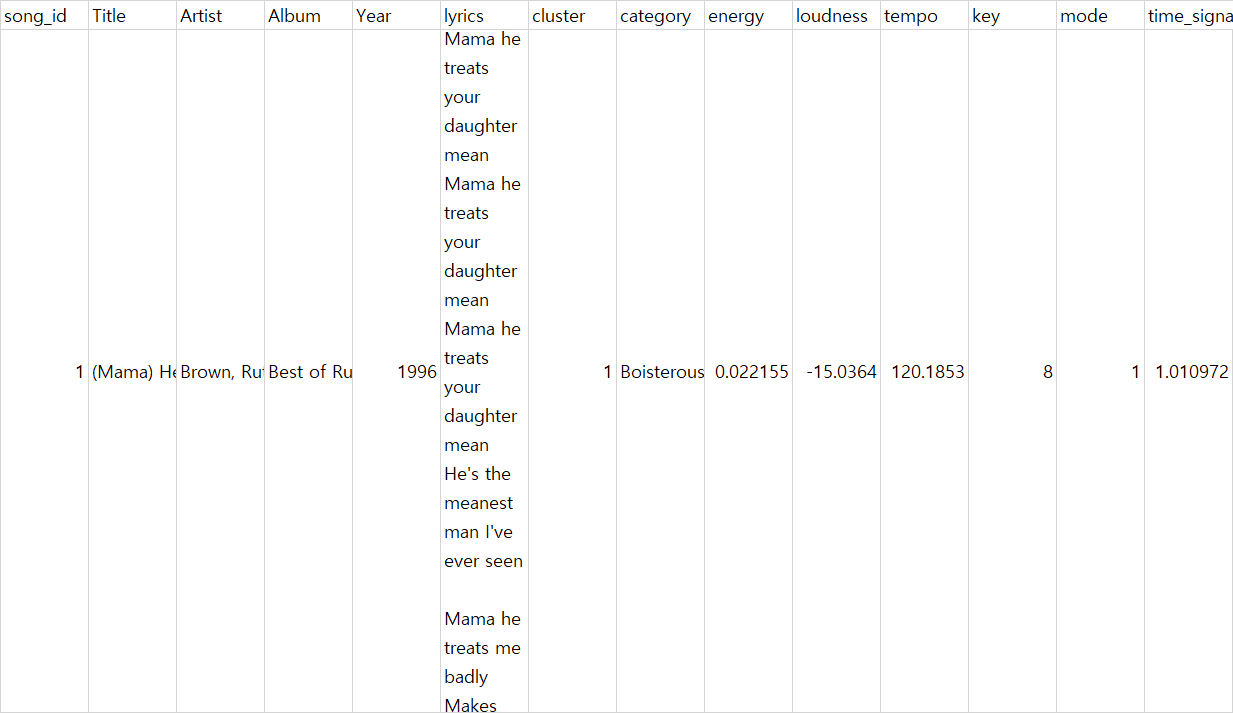

# 2) 데이터 전처리

## 오디오

### **오디오(DEAM) 피처 추출**

In [ ]:
pip install librosa

In [ ]:
import zipfile
import os

# Google Drive의 zip 파일 경로 설정
zip_file_path = "/content/drive/MyDrive/프로젝트1/OB_방학프로젝트/data/DEAM/DEAM_audio.zip"
extract_to_path = "/content/extracted_files"  # Colab의 작업 디렉토리로 설정 가능

# 디렉토리 생성 및 압축 해제
os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"파일이 {extract_to_path} 폴더에 성공적으로 압축 해제되었습니다.")

파일이 /content/extracted_files 폴더에 성공적으로 압축 해제되었습니다.


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# 오디오 특징 추출 함수
def extract_audio_features(audio_path):
    # 오디오 파일 로딩
    y, sr = librosa.load(audio_path, sr=None)

    # 1. Energy: RMS (Root Mean Square) 에너지
    energy = np.mean(librosa.feature.rms(y=y))
    '''
    # 2. Loudness: Mel-spectrogram에서 RMS 계산 (Loudness)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=512, fmax=8000)
    loudness = np.mean(librosa.feature.rms(S=S))
    '''
    # 3. Tempo (beats per minute)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

    # 4. Key: Chroma feature의 평균을 통해 추출 (0~11, 각 조성)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    key = np.argmax(np.mean(chroma, axis=1))  # 0~11 사이의 값 (C, C#, D, ...)

    # 5. Time Signature: 기본적으로 4/4박자 추정
    time_signature = 4  # 4/4박자로 가정

    # 6. Spectral Centroid: 스펙트럼 중심
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    '''
    # 7. Spectral Roll-off: 상위 주파수 비율
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_off=0.85))
    '''
    # 8. Zero Crossing Rate: 0을 통과하는 횟수
    zero_crossings = np.mean(librosa.feature.zero_crossing_rate(y=y))

    # 9. MFCC (Mel Frequency Cepstral Coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)

    # 10. Chromagram: 조화적 정보
    chroma_mean = np.mean(chroma, axis=1)

    # 11. Pitch (Average pitch)
    pitch = np.mean(librosa.core.pitch_tuning(y))


    # 특성 반환
    features = np.hstack([energy, tempo, key, time_signature,
                          spectral_centroid, zero_crossings,
                          mfcc, chroma_mean, pitch])

    return features

# 파일 경로 설정
audio_folder = '/content/extracted_files/MEMD_audio'  # 오디오 파일들이 있는 폴더 경로

# 모든 파일에 대해 특징 추출
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.mp3') or f.endswith('.wav')]

# 결과를 저장할 리스트
feature_list = []

# 오디오 파일 하나씩 처리
for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    features = extract_audio_features(audio_path)
    feature_list.append(features)
    print(f"Processed: {audio_file}")

Processed: 110.mp3
Processed: 294.mp3
Processed: 437.mp3
Processed: 183.mp3
Processed: 578.mp3
Processed: 880.mp3
Processed: 603.mp3
Processed: 103.mp3
Processed: 275.mp3
Processed: 024.mp3
Processed: 056.mp3
Processed: 236.mp3
Processed: 526.mp3
Processed: 424.mp3
Processed: 281.mp3
Processed: 809.mp3
Processed: 001.mp3
Processed: 601.mp3
Processed: 210.mp3
Processed: 271.mp3
Processed: 397.mp3
Processed: 489.mp3
Processed: 879.mp3
Processed: 050.mp3
Processed: 500.mp3
Processed: 310.mp3
Processed: 442.mp3
Processed: 590.mp3
Processed: 181.mp3
Processed: 252.mp3
Processed: 398.mp3
Processed: 845.mp3
Processed: 368.mp3
Processed: 565.mp3
Processed: 135.mp3
Processed: 525.mp3
Processed: 867.mp3
Processed: 452.mp3
Processed: 814.mp3
Processed: 794.mp3
Processed: 065.mp3
Processed: 545.mp3
Processed: 282.mp3
Processed: 674.mp3
Processed: 445.mp3
Processed: 705.mp3
Processed: 180.mp3
Processed: 207.mp3
Processed: 737.mp3
Processed: 015.mp3
Processed: 221.mp3
Processed: 797.mp3
Processed: 1

In [ ]:
# 특징들을 DataFrame에 저장
# mfcc 20개, chromagram mean 12개
columns = ['energy', 'tempo', 'key', 'time_signature',
           'spectral_centroid', 'zero_crossings',
           'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
           'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20',
           'chromagram_1', 'chromagram_2', 'chromagram_3', 'chromagram_4', 'chromagram_5',
           'chromagram_6', 'chromagram_7', 'chromagram_8', 'chromagram_9', 'chromagram_10', 'chromagram_11',
           'chromagram_12', 'pitch']

# DataFrame 생성
df_features = pd.DataFrame(feature_list, columns=columns)

print("오디오 파일 특징 추출 완료")
df_features.head()

오디오 파일 특징 추출 완료


,energy,tempo,key,time_signature,spectral_centroid,zero_crossings,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,chromagram_4,chromagram_5,chromagram_6,chromagram_7,chromagram_8,chromagram_9,chromagram_10,chromagram_11,chromagram_12,pitch
0,0.078306,123.046875,3.0,4.0,2626.028437,0.056716,-201.191574,145.294434,-37.497040,50.071308,...,0.498843,0.471424,0.462161,0.426855,0.415463,0.319428,0.281712,0.317369,0.344711,-0.40
1,0.151386,117.453835,4.0,4.0,2156.970998,0.047442,-221.365646,142.838181,-50.106934,34.875622,...,0.695319,0.707035,0.684381,0.653829,0.657718,0.585984,0.572385,0.501159,0.478961,0.43
2,0.074558,97.508844,9.0,4.0,1896.829062,0.045869,-251.190338,180.807129,-9.727378,17.603308,...,0.356247,0.548384,0.352181,0.309145,0.471678,0.452215,0.618932,0.371043,0.293397,0.17
3,0.279930,107.666016,3.0,4.0,3338.216657,0.065806,-80.253677,132.357147,-12.744441,33.859062,...,0.708948,0.671874,0.575578,0.546438,0.563617,0.541503,0.541870,0.598834,0.472406,-0.15
4,0.098719,143.554688,0.0,4.0,4019.925244,0.095885,-147.113235,117.408859,-35.458420,47.271206,...,0.521243,0.470127,0.485367,0.413117,0.436088,0.405252,0.410250,0.489180,0.476076,-0.23


In [ ]:
# song_id 추가
df_features['song_id'] = audio_files
df_features['song_id'] = df_features['song_id'].apply(lambda x : x.split('.')[0])
df_features['song_id'] = df_features['song_id'].astype(int)
df_features = df_features.sort_values(by='song_id')

# time_signature drop
df_features = df_features.drop('time_signature', axis=1)

# arousal, valence 추가
df_features = pd.merge(df_features, df[['valence_mean','arousal_mean', 'song_id']], on='song_id')
df_features.head()

# DataFrame 저장
df_features.to_csv('/content/extracted_features.csv', index=False)

,energy,tempo,key,spectral_centroid,zero_crossings,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,chromagram_7,chromagram_8,chromagram_9,chromagram_10,chromagram_11,chromagram_12,pitch,song_id,valence_mean,arousal_mean
0,0.105231,139.674831,9.0,1894.684236,0.036522,-200.259857,171.772614,-32.708050,36.403450,0.236144,...,0.461069,0.479218,0.592028,0.690916,0.555201,0.449447,-0.23,2,3.1,3.0
1,0.116200,95.703125,4.0,1043.167353,0.013482,-285.926178,159.132568,7.611665,33.757629,25.207741,...,0.649142,0.641041,0.657249,0.673871,0.635210,0.671110,0.27,3,3.5,3.3
2,0.184904,112.347147,9.0,1917.091287,0.037387,-163.723801,166.300110,-29.482483,36.676277,10.505774,...,0.314603,0.424413,0.540464,0.775640,0.575208,0.486816,0.40,4,5.7,5.5
3,0.149748,123.046875,11.0,1898.303391,0.036256,-190.341141,162.434845,-10.739487,38.936256,-6.951975,...,0.467110,0.267812,0.226276,0.222515,0.414721,0.551843,0.46,5,4.4,5.3
4,0.267147,120.185320,4.0,1269.457957,0.012908,-208.911133,156.988312,-2.480501,62.610767,13.259298,...,0.540120,0.539491,0.535097,0.532844,0.555459,0.588708,-0.43,7,5.8,6.4


### **오디오(MIREX) 피처 추출**

In [ ]:
# DEAM 피처 추출 시 사용한 함수(extract_audio_features) 사용

# 파일 경로 설정
audio_folder = '/content/extracted_files/dataset/Audio'  # 오디오 파일들이 있는 폴더 경로

# 모든 파일에 대해 특징 추출
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.mp3') or f.endswith('.wav')]

# 결과를 저장할 리스트
feature_list = []

# 오디오 파일 하나씩 처리
for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    features = extract_audio_features(audio_path)
    feature_list.append(features)
    print(f"Processed: {audio_file}")

Processed: 110.mp3
Processed: 294.mp3
Processed: 437.mp3
Processed: 183.mp3
Processed: 578.mp3
Processed: 880.mp3
Processed: 603.mp3
Processed: 103.mp3
Processed: 275.mp3
Processed: 024.mp3
Processed: 056.mp3
Processed: 236.mp3
Processed: 526.mp3
Processed: 424.mp3
Processed: 281.mp3
Processed: 809.mp3
Processed: 001.mp3
Processed: 601.mp3
Processed: 210.mp3
Processed: 271.mp3
Processed: 397.mp3
Processed: 489.mp3
Processed: 879.mp3
Processed: 050.mp3
Processed: 500.mp3
Processed: 310.mp3
Processed: 442.mp3
Processed: 590.mp3
Processed: 181.mp3
Processed: 252.mp3
Processed: 398.mp3
Processed: 845.mp3
Processed: 368.mp3
Processed: 565.mp3
Processed: 135.mp3
Processed: 525.mp3
Processed: 867.mp3
Processed: 452.mp3
Processed: 814.mp3
Processed: 794.mp3
Processed: 065.mp3
Processed: 545.mp3
Processed: 282.mp3
Processed: 674.mp3
Processed: 445.mp3
Processed: 705.mp3
Processed: 180.mp3
Processed: 207.mp3
Processed: 737.mp3
Processed: 015.mp3
Processed: 221.mp3
Processed: 797.mp3
Processed: 1

In [ ]:
# 특징들을 DataFrame에 저장
# mfcc 20개, chromagram mean 12개
columns = ['energy', 'tempo', 'key', 'time_signature',
           'spectral_centroid', 'zero_crossings',
           'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
           'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20',
           'chromagram_1', 'chromagram_2', 'chromagram_3', 'chromagram_4', 'chromagram_5',
           'chromagram_6', 'chromagram_7', 'chromagram_8', 'chromagram_9', 'chromagram_10', 'chromagram_11',
           'chromagram_12', 'pitch']

# DataFrame 생성
df_features = pd.DataFrame(feature_list, columns=columns)

print("오디오 파일 특징 추출 완료")
df_features.head()

오디오 파일 특징 추출 완료


,energy,tempo,key,time_signature,spectral_centroid,zero_crossings,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,chromagram_4,chromagram_5,chromagram_6,chromagram_7,chromagram_8,chromagram_9,chromagram_10,chromagram_11,chromagram_12,pitch
0,0.117608,114.843750,2.0,4.0,2403.261451,0.063045,-160.863495,179.218491,-66.618622,55.160526,...,0.468527,0.449919,0.392143,0.420514,0.249924,0.274487,0.458411,0.249356,0.285198,-0.34
1,0.122303,120.185320,9.0,4.0,2741.312328,0.067714,-144.642670,156.629089,-69.416824,58.877781,...,0.436517,0.527295,0.461384,0.400721,0.442927,0.565769,0.642306,0.546215,0.487268,0.34
2,0.095435,172.265625,10.0,4.0,1573.896640,0.040655,-249.314926,177.609238,-34.260658,23.818796,...,0.315084,0.339145,0.370698,0.474941,0.423630,0.435127,0.432663,0.605008,0.548788,-0.42
3,0.177462,109.956782,10.0,4.0,2994.792586,0.078543,-110.906189,140.346695,-49.163540,51.831253,...,0.432762,0.347117,0.390340,0.317058,0.401843,0.354390,0.415068,0.541787,0.443574,-0.10
4,0.113893,93.963068,11.0,4.0,2324.284305,0.059637,-199.812592,159.425507,-25.164825,38.961033,...,0.370001,0.387152,0.446566,0.558568,0.534949,0.445726,0.453288,0.574954,0.578078,-0.31


In [ ]:
# song_id 추가
df_features['song_id'] = audio_files
df_features['song_id'] = df_features['song_id'].apply(lambda x : x.split('.')[0])
df_features['song_id'] = df_features['song_id'].astype(int)
df_features = df_features.sort_values(by='song_id')

# time_signature drop
df_features = df_features.drop('time_signature', axis=1)

# DataFrame 저장
df_features.to_csv('/content/MIREX_features.csv', index=False)
df_features.head()

,energy,tempo,key,spectral_centroid,zero_crossings,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,chromagram_5,chromagram_6,chromagram_7,chromagram_8,chromagram_9,chromagram_10,chromagram_11,chromagram_12,pitch,song_id
16,0.124067,120.185320,8.0,3591.478661,0.096978,-167.851135,117.012192,-19.130047,52.945614,-8.818518,...,0.395448,0.453719,0.409305,0.379266,0.478943,0.427542,0.398660,0.411469,-0.18,1
870,0.093081,156.605114,9.0,1726.221489,0.024919,-305.011963,146.106369,17.744226,57.188725,6.587959,...,0.562601,0.539568,0.496863,0.557398,0.597193,0.608655,0.566477,0.584918,-0.16,2
247,0.135723,105.468750,9.0,2591.292266,0.058417,-159.622818,154.242218,-36.463215,49.317795,-19.480726,...,0.460174,0.392650,0.385831,0.407668,0.497981,0.535953,0.434299,0.434508,-0.46,3
59,0.173973,93.963068,2.0,2967.550972,0.088290,-91.936119,149.455826,-70.483353,38.829788,-18.723471,...,0.522607,0.454224,0.512285,0.488438,0.423991,0.445849,0.419324,0.475090,-0.09,4
106,0.117730,103.359375,6.0,2675.267259,0.066502,-158.567780,149.837906,-63.766209,50.843540,-6.133623,...,0.541554,0.524951,0.656637,0.552979,0.484303,0.459528,0.561557,0.646951,-0.24,5


- **Spectral Centroid**: 오디오 신호의 밝기나 선명도를 나타내며, 음악의 "bright" 또는 "dull"한 느낌을 반영
- **Zero Crossing Rate**: 신호가 0을 통과하는 횟수로, 오디오의 리듬과 관련
- **MFCCs** (Mel-frequency cepstral coefficients): 음성 및 음악의 특성을 나타내는 대표적인 특징들
- **Chromagram**: 오디오의 조화적인 정보(음의 고조파)를 포함
- **RMSE** (Root Mean Square Error): 신호의 에너지 변화를 나타냄
- **Pitch**: 음의 높낮이로, 감정의 변화를 반영

### **스케일링**

- **DEAM** 데이터

In [ ]:
X = df_features.drop(['valence_mean', 'arousal_mean'], axis=1)
X = X.set_index('song_id')
y = df_features[['valence_mean', 'arousal_mean']]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.28174524,  0.23199982,  0.93446287,  1.04329243,  0.38292456],
       [-0.08553661, -0.40649855, -1.3777113 , -0.39600703,  0.21859548],
       [ 0.74057024,  0.76869426, -0.50251494,  1.04329243,  0.47880009],
       ...,
       [-0.40505452, -0.45048895, -1.18415826, -0.39600703,  0.02329117],
       [ 0.51571741,  1.44889084,  0.21792109,  1.61901221,  0.24963259],
       [ 0.07270923,  0.49827067, -0.62820803,  0.17971275,  0.08767749]])

In [ ]:
y_a = deam['arousal_mean']
y_a

,arousal_mean
0,3.00
1,3.30
2,5.50
3,5.30
4,6.40
...,...
1797,3.60
1798,5.20
1799,4.60
1800,6.83


In [ ]:
scaler_a = StandardScaler()
y_a_scaled = scaler_a.fit_transform(y_a.values.reshape(-1, 1))
y_a_scaled

array([[-1.41518526],
       [-1.18114512],
       [ 0.53514929],
       ...,
       [-0.16697115],
       [ 1.57272727],
       [ 0.76918943]])

In [ ]:
y_v = y['valence_mean']
y_v

,valence_mean
0,3.10
1,3.50
2,5.70
3,4.40
4,5.80
...,...
1797,5.40
1798,5.00
1799,5.00
1800,3.17


In [ ]:
scaler_v = StandardScaler()
y_v_scaled = scaler_v.fit_transform(y_v.values.reshape(-1, 1))
y_v_scaled

array([[-1.53686358],
       [-1.19612306],
       [ 0.67794977],
       ...,
       [ 0.08165387],
       [-1.47723399],
       [-0.94056768]])

- **MIREX** 데이터

In [ ]:
df_features = pd.read_csv('/content/MIREX_features.csv')

X_m = df_features.copy()
X_m = X_m.set_index('song_id')
X_m.head()

,energy,tempo,key,spectral_centroid,zero_crossings,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,chromagram_4,chromagram_5,chromagram_6,chromagram_7,chromagram_8,chromagram_9,chromagram_10,chromagram_11,chromagram_12,pitch
song_id,,,,,,,,,,,,,,,,,,,,,
1,0.124067,120.185320,8.0,3591.478661,0.096978,-167.851135,117.012192,-19.130047,52.945614,-8.818518,...,0.474740,0.395448,0.453719,0.409305,0.379266,0.478943,0.427542,0.398660,0.411469,-0.18
2,0.093081,156.605114,9.0,1726.221489,0.024919,-305.011963,146.106369,17.744226,57.188725,6.587959,...,0.568565,0.562601,0.539568,0.496863,0.557398,0.597193,0.608655,0.566477,0.584918,-0.16
3,0.135723,105.468750,9.0,2591.292266,0.058417,-159.622818,154.242218,-36.463215,49.317795,-19.480726,...,0.400504,0.460174,0.392650,0.385831,0.407668,0.497981,0.535953,0.434299,0.434508,-0.46
4,0.173973,93.963068,2.0,2967.550972,0.088290,-91.936119,149.455826,-70.483353,38.829788,-18.723471,...,0.521075,0.522607,0.454224,0.512285,0.488438,0.423991,0.445849,0.419324,0.475090,-0.09
5,0.117730,103.359375,6.0,2675.267259,0.066502,-158.567780,149.837906,-63.766209,50.843540,-6.133623,...,0.617413,0.541554,0.524951,0.656637,0.552979,0.484303,0.459528,0.561557,0.646951,-0.24


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_m = StandardScaler()
Xm_scaled = scaler_m.fit_transform(X_m)

## 텍스트

### 가사 전처리

MIREX dataset `lyrics` 행의 가사 데이터 전처리
- 텍스트 클리닝
- 가사 요약

In [ ]:
mirex = pd.read_csv('./MIREX/dataset/MIREX_lyrics.csv')
mirex.head()

,song_id,Title,Artist,Album,Year,lyrics,cluster,category,energy,loudness,tempo,key,mode,time_signature
0,1,(Mama) He Treats Your Daughter Mean,"Brown, Ruth",Best of Ruth Brown [Rhino],1996.0,Mama he treats your daughter mean \nMama he tr...,1,Boisterous,0.022155,-15.036412,120.185320,8,1,1.010972
1,2,Night in Tunisia,"Blakey, Art & the Jazz Messengers",Night in Tunisia [1960],1960.0,Unknown,1,Boisterous,0.010367,-26.363678,156.605114,9,1,0.893642
2,3,Along Came Jones,Coasters,50 Coastin' Classics: Anthology,1992.0,I plopped down in my easy chair and turned on ...,1,Boisterous,0.022840,-17.429565,105.468750,9,1,0.974649
3,4,Back in Black,AC/DC,Back in Black,1980.0,Back in black \nI hit the sack \nIt's been too...,1,Boisterous,0.035078,-12.957283,93.963068,2,1,0.925274
4,5,Bad Reputation,"Jett, Joan & Teh Blackhearts",Bad Reputation [Bonus Tracks],1992.0,I don't give a damn 'bout my reputation\nLivin...,1,Boisterous,0.015994,-18.270273,103.359375,6,1,0.964630


1. 결측치 처리

In [ ]:
mirex = pd.read_csv('./MIREX/dataset/MIREX_lyrics.csv')
print(mirex.shape)

# 결측치: 가사가 없는 곡은 삭제
unk_idx = mirex[mirex['lyrics']=='Unknown'].index
print(unk_idx)

mirex = mirex.drop(unk_idx).reset_index(drop=True)
print(mirex.shape)

(903, 14)
Index([  1,   5,  25,  30,  69,  75,  79,  92, 106, 145, 155, 160, 162, 175,
       183, 186, 206, 264, 329, 358, 376, 414, 442, 456, 522, 524, 545, 564,
       575, 594, 748, 765, 767, 771, 773, 774, 777, 779, 788, 789, 792, 800,
       804, 805, 845, 854, 864, 865, 867, 880, 890, 891, 892, 895],
      dtype='int64')
(849, 14)


2. 가사 요약
  
  **T5 (Text-to-Text Transfer Transformer) 모델**
  - 구글에서 개발한 자연어 처리 모델
  - 모든 NLP 작업을 텍스트-입력과 텍스트-출력의 형태로 변환하여 처리
  ➡️ 가사 요약 작업을 수행

  **`T5ForConditionalGeneration`**
  - 입력 텍스트 기반으로 출력을 생성하는 조건부 생성 모델(사전 학습 모델)

In [ ]:
#!pip install SentencePiece
from transformers import T5Tokenizer, T5ForConditionalGeneration

# tokenizer, model 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(device)

def summarize_lyrics(lyrics):
    try:
        # 입력 텍스트 및 토큰화
        inputs = tokenizer.encode("summarize lyrics: " + lyrics, return_tensors="pt", max_length=512, truncation=True).to(device)

        # 요약문 생성
        outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4)

        # 텍스트로 변환(decoding)
        return tokenizer.decode(outputs[0])

    except Exception as e:
        print(f"Error in summarizing lyrics: {e}")
        return None

In [ ]:
summary_list = []
for line in tqdm(mirex['lyrics']):
    summary_list.append(summarize_lyrics(line))

mirex['summary'] = summary_list

100%|████████████████████████████████████████████████████████████████████████████████| 849/849 [19:46<00:00,  1.40s/it]


- la la la 와 같은 무의미한 반복 구문이 중요한 문장으로 인식되는 경우 발생
  - 반복 구문을 탐지하고 제거하는 전처리 후 재요약

In [ ]:
from collections import Counter
import re

def clean_repeated_text(text):
    # 소문자화
    text = text.lower()

    # 반복 구문 제거 (1번만 남기기)
    pattern = r'\b(.+?)(?:\s+\1)+\b'
    while re.search(pattern, text, re.DOTALL):
        text = re.sub(pattern, r'\1', text, flags=re.DOTALL)

    # 공백 및 줄바꿈 정리
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
my_cleaned_list = []
for line in tqdm(mirex['lyrics']):
    my_cleaned_list.append(clean_repeated_text(line))

100%|████████████████████████████████████████████████████████████████████████████████| 849/849 [00:15<00:00, 53.13it/s]


In [ ]:
# 반복 구문이 제거된 가사
mirex['my_clean_lyrics'] = my_cleaned_list
mirex[['lyrics', 'my_clean_lyrics']].head()

,lyrics,my_clean_lyrics
0,Mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen \n\nMama he treats me badly \nMakes me love him madly \nMama he takes my money \nMakes me call him honey \n\nMama he can't be trusted \nHe makes me so disgusted \nAll of my friends they don't understand \nWhat's the matter with this man \n\nI tell you mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen \n\nMama this man is lazy \nAlmost drives me crazy \nMama he makes me squeeze him \nStill my squeezes don't please him \n\nMama my heart is aching \nI believe it's breaking \nI've stood all that I can stand \nWhat's the matter with this man? \n\nI tell you Mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen\n,mama he treats your daughter mean he's the meanest man i've ever seen mama he treats me badly makes me love him madly mama he takes my money makes me call him honey mama he can't be trusted he makes me so disgusted all of my friends they don't understand what's the matter with this man i tell you mama he treats your daughter mean he's the meanest man i've ever seen mama this man is lazy almost drives me crazy mama he makes me squeeze him still my squeezes don't please him mama my heart is aching i believe it's breaking i've stood all that i can stand what's the matter with this man? i tell you mama he treats your daughter mean he's the meanest man i've ever seen
1,"I plopped down in my easy chair and turned on Channel 2\nA bad gunslinger called Salty Sam was chasin' poor Sweet Sue\nHe trapped her in the old sawmill and said with an evil laugh,\n""If you don't give me the deed to your ranch\nI'll saw you all in half!""\nAnd then he grabbed her (and then)\nHe tied her up (and then)\nHe turned on the bandsaw (and then, and then...!)\n\n[Chorus:]\nAnd then along came Jones\nTall thin Jones\nSlow-walkin' Jones\nSlow-talkin' Jones\nAlong came long, lean, lanky Jones\n\nCommercial came on, so I got up to get myself a snack\nYou should've seen what was goin' on by the time that I got back\nDown in the old abandoned mine, Sweet Sue was havin' fits\nThat villain said, ""Give me the deed to your ranch\nOr I'll blow you all to bits!""\nAnd then he grabbed her (and then)\nHe tied her up (and then)\nHe lit the fuse to the dynamite (and then, and then...!)\n\n[Chorus]\n\nI got so bugged I turned it off and turned on another show\nBut there was the same old shoot-'em-up and the same old rodeo\nSalty Sam was tryin' to stuff Sweet Sue in a burlap sack\nHe said, ""If you don't give me the deed to your ranch\nI'm gonna throw you on the railroad tracks!""\nAnd then he grabbed her (and then)\nHe tied her up (and then)\nHe threw her on the railroad tracks (and then)\nA train started comin' (and then, and then...!)\n\n[Chorus]\n","i plopped down in my easy chair and turned on channel 2 a bad gunslinger called salty sam was chasin' poor sweet sue he trapped her in the old sawmill and said with an evil laugh, ""if you don't give me the deed to your ranch i'll saw you all in half!"" and then he grabbed her (and then) he tied her up (and then) he turned on the bandsaw (and then, and then...!) [chorus:] and then along came jones tall thin jones slow-walkin' jones slow-talkin' jones along came long, lean, lanky jones commercial came on, so i got up to get myself a snack you should've seen what was goin' on by the time that i got back down in the old abandoned mine, sweet sue was havin' fits that villain said, ""give me the deed to your ranch or i'll blow you all to bits!"" and then he grabbed her (and then) he tied her up (and then) he lit the fuse to the dynamite (and then, and then...!) [chorus] i got so bugged i turned it off and turned on another show but there was the same old shoot-'em-up and the sam

In [ ]:
# 재요약
re_summary_list = []
for line in tqdm(mirex['my_clean_lyrics']):
    re_summary_list.append(summarize_lyrics(line))

mirex['my_summary_lyrics'] = re_summary_list

100%|████████████████████████████████████████████████████████████████████████████████| 849/849 [19:31<00:00,  1.38s/it]


In [ ]:
mirex.head()

,song_id,Title,Artist,Album,Year,lyrics,cluster,category,energy,loudness,tempo,key,mode,time_signature,my_clean_lyrics,my_summary_lyrics
0,1,(Mama) He Treats Your Daughter Mean,"Brown, Ruth",Best of Ruth Brown [Rhino],1996.0,Mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen \n\nMama he treats me badly \nMakes me love him madly \nMama he takes my money \nMakes me call him honey \n\nMama he can't be trusted \nHe makes me so disgusted \nAll of my friends they don't understand \nWhat's the matter with this man \n\nI tell you mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen \n\nMama this man is lazy \nAlmost drives me crazy \nMama he makes me squeeze him \nStill my squeezes don't please him \n\nMama my heart is aching \nI believe it's breaking \nI've stood all that I can stand \nWhat's the matter with this man? \n\nI tell you Mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen\n,1,Boisterous,0.022155,-15.036412,120.185320,8,1,1.010972,mama he treats your daughter mean he's the meanest man i've ever seen mama he treats me badly makes me love him madly mama he takes my money makes me call him honey mama he can't be trusted he makes me so disgusted all of my friends they don't understand what's the matter with this man i tell you mama he treats your daughter mean he's the meanest man i've ever seen mama this man is lazy almost drives me crazy mama he makes me squeeze him still my squeezes don't please him mama my heart is aching i believe it's breaking i've stood all that i can stand what's the matter with this man? i tell you mama he treats your daughter mean he's the meanest man i've ever seen,i tell you mama he treats your daughter mean he's the meanest man i've ever seen mama this man is lazy almost drives me crazy mama he makes me squeeze him still my squeezes don't please him mama my heart is aching i believe it's breaking i've stood all that i can stand what's the matter with this man i tell you mama he treats your daughter mean he's the meanest man i've ever seen mama this man is lazy almost
1,3,Along Came Jones,Coasters,50 Coastin' Classics: Anthology,1992.0,"I plopped down in my easy chair and turned on Channel 2\nA bad gunslinger called Salty Sam was chasin' poor Sweet Sue\nHe trapped her in the old sawmill and said with an evil laugh,\n""If you don't give me the deed to your ranch\nI'll saw you all in half!""\nAnd then he grabbed her (and then)\nHe tied her up (and then)\nHe turned on the bandsaw (and then, and then...!)\n\n[Chorus:]\nAnd then along came Jones\nTall thin Jones\nSlow-walkin' Jones\nSlow-talkin' Jones\nAlong came long, lean, lanky Jones\n\nCommercial came on, so I got up to get myself a snack\nYou should've seen what was goin' on by the time that I got back\nDown in the old abandoned mine, Sweet Sue was havin' fits\nThat villain said, ""Give me the deed to your ranch\nOr I'll blow you all to bits!""\nAnd then he grabbed her (and then)\nHe tied her up (and then)\nHe lit the fuse to the dynamite (and then, and then...!)\n\n[Chorus]\n\nI got so bugged I turned it off and turned on another show\nBut there was the same old shoot-'em-up and the same old rodeo\nSalty Sam was tryin' to stuff Sweet Sue in a burlap sack\nHe said, ""If you don't give me the deed to your ranch\nI'm gonna throw you on the railroad tracks!""\nAnd then he grabbed her (and then)\nHe tied her up (and then)\nHe threw her on the railroad tracks (and then)\nA train started comin' (and then, and then...!)\n\n[Chorus]\n",1,Boisterous,0.022840,-17.429565,105.468750,9,1,0.974649,"i plopped down in my easy chair and turned on channel 2 a bad gunslinger called salty sam was chasin' poor sweet sue he trapped her in the old sawmill and said with an evil laugh, ""if you don't g

# 3) 감정 추출 모델링

## 오디오

### arousal 회귀 모델 - 앙상블

- **DEAM 데이터를 이용해 회귀 모델 학습**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_a_scaled, test_size=0.2, random_state=42)

# 모델 초기화
models = {
    "RandomForest": RandomForestRegressor(max_depth=30, n_estimators=200, min_samples_split= 2, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, gamma=0.1, random_state=42),
    "LGBM": LGBMRegressor(n_estimators=100, max_depth=7, learning_rate=0.05, random_state=42),
    "Ridge": Ridge(alpha=600)
}

# 각 모델 훈련
for name, model in models.items():
    model.fit(X_train, y_train)

# 가중치 설정
weights = [0.4, 0.2, 0.4, 0]  # RandomForest, XGBoost, LGBM, Ridge 순

# 가중치 앙상블
predictions = np.column_stack([model.predict(X_test) for model in models.values()])
ensemble_weighted_pred = np.average(predictions, axis=1, weights=weights)

# 성능 평가
r2_weighted = r2_score(y_test, ensemble_weighted_pred)
print(f"R2 Score with Weighted Ensemble (Arousal): {r2_weighted}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9075
[LightGBM] [Info] Number of data points in the train set: 1441, number of used features: 38
[LightGBM] [Info] Start training from score 0.013364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


- **학습시킨 앙상블 모델에 MIREX 데이터를 넣어 arousal 값 예측**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

# 가중치 앙상블
predictions = np.column_stack([model.predict(Xm_scaled) for model in models.values()])
ensemble_weighted_pred = np.average(predictions, axis=1, weights=weights)

y_pred_original = scaler3.inverse_transform(ensemble_weighted_pred.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
df_info['arousal'] = y_pred_original
df_info.head()

,Title,Artist,Album,Track,Year,Length,Size,Last Modified,Filename,arousal
0,(Mama) He Treats Your Daughter Mean,"Brown, Ruth",Best of Ruth Brown [Rhino],8,1996.0,30.0,"352,00 KB",09-09-2010,001.mp3,5.247192
1,Night in Tunisia,"Blakey, Art & the Jazz Messengers",Night in Tunisia [1960],1,1960.0,30.0,"348,00 KB",09-09-2010,002.mp3,3.710132
2,Along Came Jones,Coasters,50 Coastin' Classics: Anthology,27,1992.0,30.0,"352,00 KB",09-09-2010,003.mp3,5.207938
3,Back in Black,AC/DC,Back in Black,6,1980.0,30.0,"352,00 KB",09-09-2010,004.mp3,6.264377
4,Bad Reputation,"Jett, Joan & Teh Blackhearts",Bad Reputation [Bonus Tracks],1,1992.0,29.0,"340,00 KB",09-09-2010,005.mp3,5.282798


### valence 회귀 모델

- **DEAM 데이터를 이용해 회귀 모델 학습**

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# 모델 학습
model = RandomForestRegressor(max_depth=7, min_samples_split=2, n_estimators=110, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold

# 교차검증 실행
scores = cross_val_score(model, X_scaled, y_v_scaled, cv=kf, scoring='r2')

# 결과 출력
print("교차검증 r2 점수:", scores)
print("평균 r2:", scores.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

교차검증 r2 점수: [0.33312483 0.39162019 0.42106474 0.40445109 0.41899452]
평균 r2: 0.3938510754935253


- **학습시킨 회귀 모델에 MIREX 데이터를 넣어 valence 값 예측**

In [ ]:
# 모델 학습(전체 데이터 사용)
model = RandomForestRegressor(max_depth=7, min_samples_split=2, n_estimators=110, random_state=42)
model.fit(X_scaled, y_v_scaled)

# prediction 역변환
pred = model.predict(Xm_scaled)
y_pred_original = scaler_v.inverse_transform(pred.reshape(-1, 1))

In [ ]:
df_info = pd.read_csv('/content/dataset_info.csv', sep=';')  # 문제 발생하는 row skip하고 파일 불러오기
df_info = df_info.drop(df_info.columns[-1], axis=1)

df_info['valence'] = y_pred_original
df_info.head()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,Title,Artist,Album,Track,Year,Length,Size,Last Modified,Filename,arousal,valence
0,(Mama) He Treats Your Daughter Mean,"Brown, Ruth",Best of Ruth Brown [Rhino],8,1996.0,30.0,"352,00 KB",09-09-2010,001.mp3,5.247192,5.383711
1,Night in Tunisia,"Blakey, Art & the Jazz Messengers",Night in Tunisia [1960],1,1960.0,30.0,"348,00 KB",09-09-2010,002.mp3,3.710132,3.575439
2,Along Came Jones,Coasters,50 Coastin' Classics: Anthology,27,1992.0,30.0,"352,00 KB",09-09-2010,003.mp3,5.207938,5.093174
3,Back in Black,AC/DC,Back in Black,6,1980.0,30.0,"352,00 KB",09-09-2010,004.mp3,6.264377,6.150010
4,Bad Reputation,"Jett, Joan & Teh Blackhearts",Bad Reputation [Bonus Tracks],1,1992.0,29.0,"340,00 KB",09-09-2010,005.mp3,5.282798,5.166144


In [ ]:
df_info.to_csv('mirex_av.csv', index=False)

## **텍스트**

### **Arousal 회귀 모델**
BERT 사전 모델(`BertForSequenceClassification`) + dropout 조절

Train $R^2$와 Test $R^2$ 값의 차이가 발생한 것으로 보아 과적합이 일어났다고 판단하였고 다음 3가지 솔루션을 적용한다.
1. Standard Scale
2. `hidden_dropout_prob=0.3`
  * BERT 모델의 히든 레이어 드롭아웃 확률을 0.3으로 설정하여 과적합을 방지한다.
  * 기본값 0.1
3. `attention_probs_dropout_prob=0.3`
  * BERT의 어텐션 확률 드롭아웃을 0.3으로 설정하여 과적합을 방지한다.
  * 어텐션 가중치에서 일부를 무작위로 제거(dropout)하여 모델의 일반화를 돕는다.
  * 기본값 0.1

#### **라이브러리**

In [ ]:
import pandas as pd

#그래프
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# 스케일링
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

# 토큰화
from transformers import BertTokenizer

# 모델 학습
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_scheduler
from torch.nn import MSELoss

# 평가 함수
from sklearn.metrics import r2_score

#### **train, test split**

In [ ]:
# 데이터셋 분리 및 표준화
X_train, X_test, y_a_train, y_a_test = train_test_split(
    emobank['text'], emobank['A'], test_size=0.2, random_state=42
)
scaler = StandardScaler()
y_a_train_scaled = scaler.fit_transform(np.array(y_a_train).reshape(-1, 1)).flatten()
y_a_test_scaled = scaler.transform(np.array(y_a_test).reshape(-1, 1)).flatten()

#### **모델 학습**

In [ ]:
# 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
# PyTorch 데이터셋 클래스
class ValueDataset(Dataset):
    def __init__(self, encodings, values):
        self.encodings = encodings
        self.values = list(values)

    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["values"] = torch.tensor(self.values[idx], dtype=torch.float)
        return item

train_dataset = ValueDataset(train_encodings, y_a_train_scaled)
test_dataset = ValueDataset(test_encodings, y_a_test_scaled)

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = BertConfig.from_pretrained(
    "bert-base-uncased", hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3, num_labels=1
)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
model.to(device)

# 옵티마이저, 학습률 스케줄러, 손실함수
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.03)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
loss_fn = MSELoss()

# 학습 함수
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses, r2_scores = [], []

    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["values"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze()
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        if len(targets) > 1:  # 최소 샘플 2개일 때만 R² 계산
            r2_scores.append(r2_score(targets.cpu().numpy(), preds.detach().cpu().numpy()))

    return np.mean(losses), np.nanmean(r2_scores)

# 평가 함수
def evaluate_epoch(model, data_loader, loss_fn, device):
    model.eval()
    losses, r2_scores = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["values"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()
            loss = loss_fn(preds, targets)

            losses.append(loss.item())
            if len(targets) > 1:
                r2_scores.append(r2_score(targets.cpu().numpy(), preds.cpu().numpy()))

    return np.mean(losses), np.nanmean(r2_scores)

In [ ]:
# 학습 및 평가 루프
num_epochs = 10
best_test_r2, patience, patience_counter = -float("inf"), 3, 0

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_r2 = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    test_loss, test_r2 = evaluate_epoch(model, test_loader, loss_fn, device)

    print(f"Train Loss: {train_loss:.4f} | Train R²: {train_r2:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test R²: {test_r2:.4f}")

    if test_r2 > best_test_r2:
        best_test_r2 = test_r2
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# 최종 R² 출력
print(f"\nBest Test R²: {best_test_r2:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10
Train Loss: 0.9912 | Train R²: -0.0341
Test Loss: 0.8227 | Test R²: 0.1264

Epoch 2/10
Train Loss: 0.8287 | Train R²: 0.1206
Test Loss: 0.6999 | Test R²: 0.2308

Epoch 3/10
Train Loss: 0.7037 | Train R²: 0.2431
Test Loss: 0.6506 | Test R²: 0.2741

Epoch 4/10
Train Loss: 0.6589 | Train R²: 0.2892
Test Loss: 0.6451 | Test R²: 0.2798

Epoch 5/10
Train Loss: 0.6213 | Train R²: 0.3222
Test Loss: 0.6759 | Test R²: 0.2391

Epoch 6/10
Train Loss: 0.5899 | Train R²: 0.3520
Test Loss: 0.6466 | Test R²: 0.2759

Epoch 7/10
Train Loss: 0.5633 | Train R²: 0.3780
Test Loss: 0.6645 | Test R²: 0.2503
Early stopping triggered.


#### **예측**

과적합 방지를 위해 Standard Scaler를 적용했으므로 예측 시 스케일 복원 과정이 필요하다.

##### **1. 가사 예측**

In [ ]:
# 데이터와 모델 경로 설정
data_path = '/content/drive/MyDrive/24-2/ESAA/프로젝트3/MIREX_lyrics_clean_summarize.csv'  # MIREX 데이터 경로
model_path = "/content/drive/MyDrive/24-2/ESAA/프로젝트3/trained_bert_model_a.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기
data = pd.read_csv(data_path)
lyrics = data["my_summary_lyrics"].astype(str).tolist()  # 'my_summary_lyrics' 열 가져오기

# 토크나이저 및 모델 불러오기
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)  # 회귀 문제
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# 데이터 토큰화 및 배치 처리
def preprocess_data(text_list, tokenizer, max_length=128):
    return tokenizer(
        text_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    )

inputs = preprocess_data(lyrics, tokenizer)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# 예측
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = outputs.logits.squeeze(-1).cpu().numpy()

# Inverse Transform으로 복원
scaler = joblib.load('/content/drive/MyDrive/24-2/ESAA/프로젝트3/scaler.pkl')
original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# 결과 저장
data["predicted_a"] = original_predictions

##### **2. 책 예측**

In [ ]:
# (데이터 불러오는 과정 생략)
# `책 소개`, `책속으로`, `서평` 열 결합
filtered_data["combined_text"] = (
    filtered_data["책소개"].fillna("") + " " +
    filtered_data["책속으로"].fillna("") + " " +
    filtered_data["서평"].fillna("")
)

# 결합된 텍스트 리스트 생성
texts = filtered_data["combined_text"].tolist()

# 모델 및 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)  # 회귀 문제
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# 데이터 토큰화 및 배치 처리
def preprocess_data(text_list, tokenizer, max_length=128):
    return tokenizer(
        text_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    )

inputs = preprocess_data(texts, tokenizer)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# 예측
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = outputs.logits.squeeze(-1).cpu().numpy()

scaler = joblib.load('/content/drive/MyDrive/24-2/ESAA/프로젝트3/scaler.pkl')

original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# 결과 저장
filtered_data["predicted_a"] = original_predictions

### **Valence 회귀 모델**

BERT 사전 모델(`BertForSequenceClassification`)

Arousal과 달리 과적합 문제가 없었기 때문에 BERT 사전 모델을 그대로 적용하였다.

#### **모델 학습**

In [ ]:
num_epochs = 300

# 모델 설정
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.to(device)

# 옵티마이저 및 손실함수
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = MSELoss()

# 학습 함수
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    r2_scores = []
    for batch_idx, d in enumerate(data_loader, 1):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["values"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze()
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        r2 = r2_score(targets.detach().cpu().numpy(), preds.detach().cpu().numpy())
        r2_scores.append(r2)

        print(f"\rEpoch {epoch}/{num_epochs} {batch_idx}/{len(data_loader)} "
              f"- loss: {loss.item():.4f} - r2_score: {r2:.4f}", end="")

    return losses, r2_scores

train_losses = []
train_r2_scores = []

# 학습 루프
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    train_loss, train_r2_score = train_epoch(model, train_loader, loss_fn, optimizer, device)
    train_losses.extend(train_loss)
    train_r2_scores.extend(train_r2_score)
    print(f"Train loss: {np.mean(train_losses):.4f} - Train R2 score: {np.mean(train_r2_scores):.4f}")

print(f"\nFinal Train loss: {np.mean(train_losses):.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/300
Epoch 1/300 252/252 - loss: 0.0730 - r2_score: -0.1388Train loss: 0.9204 - Train R2 score: -8.6219

Epoch 2/300
Epoch 2/300 252/252 - loss: 0.0596 - r2_score: 0.1962Train loss: 0.5085 - Train R2 score: -4.2363

Epoch 3/300
Epoch 3/300 252/252 - loss: 0.0537 - r2_score: 0.3757Train loss: 0.3631 - Train R2 score: -2.7061

Epoch 4/300
Epoch 4/300 252/252 - loss: 0.0670 - r2_score: 0.6587Train loss: 0.2866 - Train R2 score: -1.9084

Epoch 5/300
Epoch 5/300 252/252 - loss: 0.0323 - r2_score: 0.6515Train loss: 0.2390 - Train R2 score: -1.4147

Epoch 6/300
Epoch 6/300 252/252 - loss: 0.0244 - r2_score: 0.8428Train loss: 0.2060 - Train R2 score: -1.0759

Epoch 7/300
Epoch 7/300 252/252 - loss: 0.0333 - r2_score: 0.6650Train loss: 0.1816 - Train R2 score: -0.8261

Epoch 8/300
Epoch 8/300 252/252 - loss: 0.0327 - r2_score: 0.7689Train loss: 0.1627 - Train R2 score: -0.6332

Epoch 9/300
Epoch 9/300 252/252 - loss: 0.0166 - r2_score: 0.7693Train loss: 0.1477 - Train R2 score: -0.4808


#### **예측**

##### **1. 가사 예측**

In [ ]:
# 데이터와 모델 경로 설정
data_path = '/content/drive/MyDrive/24-2/ESAA/프로젝트3/MIREX_lyrics_clean_summarize.csv'  # MIREX 데이터 경로
model_path = "/content/drive/MyDrive/24-2/ESAA/프로젝트3/trained_bert_model_v.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기
data = pd.read_csv(data_path)
lyrics = data["my_summary_lyrics"].astype(str).tolist()  # 'my_summary_lyrics' 열 가져오기

# 토크나이저 및 모델 불러오기
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)  # 회귀 문제
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# 데이터 토큰화 및 배치 처리
def preprocess_data(text_list, tokenizer, max_length=128):
    return tokenizer(
        text_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    )

inputs = preprocess_data(lyrics, tokenizer)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# 예측
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = outputs.logits.squeeze(-1).cpu().numpy()

# 결과 저장
data["predicted_v"] = predictions

##### **2. 책 예측**

In [ ]:
# (데이터 불러오는 과정 생략)
# `책 소개`, `책속으로`, `서평` 열 결합
filtered_data["combined_text"] = (
    filtered_data["책소개"].fillna("") + " " +
    filtered_data["책속으로"].fillna("") + " " +
    filtered_data["서평"].fillna("")
)

# 결합된 텍스트 리스트 생성
texts = filtered_data["combined_text"].tolist()

# 모델 및 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)  # 회귀 문제
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# 데이터 토큰화 및 배치 처리
def preprocess_data(text_list, tokenizer, max_length=128):
    return tokenizer(
        text_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length
    )

inputs = preprocess_data(texts, tokenizer)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# 예측 수행
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = outputs.logits.squeeze(-1).cpu().numpy()

# 결과 저장
filtered_data["predicted_v"] = predictions

# 4) 추천시스템

## 유클리디안 유사도 계산

DEAM(오디오 데이터)과 Emobank(텍스트 데이터)의 A와 V 값의 스케일이 먼저, 각각 1에서 9, 1에서 5로 달랐기 때문에 각각의 train 데이터에 적용한 minmax scaler를 객체로 가져와 예측 데이터를 스케일링한다.

In [ ]:
# MinMaxScaler 불러오기
a_minmax_scaler = joblib.load("/content/drive/MyDrive/24-2/ESAA/프로젝트3/final/a_minmax_scaler.pkl")
v_minmax_scaler = joblib.load("/content/drive/MyDrive/24-2/ESAA/프로젝트3/final/v_minmax_scaler.pkl")

# MIREX_av 파일 불러오기
MIREX_av = pd.read_csv("/content/drive/MyDrive/24-2/ESAA/프로젝트3/MIREX/MIREX_av.csv")

# lyrics_a와 lyrics_v 컬럼 추출 및 스케일링
MIREX_av['lyrics_a_minmax'] = a_minmax_scaler.transform(MIREX_av[['lyrics_a']])
MIREX_av['lyrics_v_minmax'] = v_minmax_scaler.transform(MIREX_av[['lyrics_v']])

# a와 v 열 스케일링
books_av['a_minmax'] = a_minmax_scaler.transform(books_av[['a']])
books_av['v_minmax'] = v_minmax_scaler.transform(books_av[['v']])

* **책-가사 유사도**

In [ ]:
# 필요한 열 추출
books_features = books_av[['a_minmax', 'v_minmax']].values
MIREX_features = MIREX_av[['lyrics_a_minmax', 'lyrics_v_minmax']].values

# 유클리드 거리 계산
distance_matrix = cdist(books_features, MIREX_features, metric='euclidean')

# 유클리드 유사도: 1 / (1 + 거리)
similarity_matrix = 1 / (1 + distance_matrix)

# DataFrame 저장
similarity_df = pd.DataFrame(similarity_matrix,
                             index=books_av.index,
                             columns=MIREX_av.index)

* **책-오디오 유사도**

In [ ]:
from joblib import load

# MinMaxScaler 불러오기
audio_a_scaler = load(open('./audio_a_scaler.pkl', 'rb'))
audio_v_scaler = load(open('./audio_v_scaler.pkl', 'rb'))
text_a_scaler = load((open('./a_minmax_scaler.pkl', 'rb')))
text_v_scaler = load((open('./v_minmax_scaler.pkl', 'rb')))

# mirex의 audio_a와 audio_v 컬럼 추출 및 스케일링
mirex['audio_a_scaled'] = audio_a_scaler.transform(mirex_df[['audio_a']])
mirex['audio_v_scaled'] = audio_v_scaler.transform(mirex_df[['audio_v']])
# book의 book_a와 book_v 컬럼 추출 및 스케일링
book['book_a_scaled'] = text_a_scaler.transform(book_df[['book_a']])
book['book_v_scaled'] = text_v_scaler.transform(book_df[['book_v']])

# 필요한 열 추출
book_features = book[['book_a_scaled', 'book_v_scaled']].values
mirex_features = mirex[['audio_a_scaled', 'audio_v_scaled']].values

# 유클리드 거리 계산
distance_matrix = cdist(book_features, mirex_features, metric='euclidean')

# 유클리드 유사도: 1 / (1 + 거리)
similarity_matrix = 1 / (1 + distance_matrix)

# DataFrame 저장
similarity_df = pd.DataFrame(similarity_matrix,
                             index=book.index,
                             columns=mirex.index)

## 코사인 유사도 계산

- **책-오디오 유사도**

In [ ]:
mirex = pd.read_csv('/content/(최종)MIREX_av.csv')
books = pd.read_csv('/content/(최종)books_av.csv')

In [ ]:
audio = mirex[['arousal', 'valence']]
book = books[['a', 'v']]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(book, audio)
print(cos_sim)

[[0.99999983 0.99949081 0.99969822 ... 0.99962867 0.99878794 0.99920482]
 [0.99858096 0.99975903 0.99957083 ... 0.99671163 0.99468916 0.99990221]
 [0.99833863 0.99965353 0.99943323 ... 0.99634791 0.99422975 0.99983153]
 [0.9999631  0.99974155 0.99988156 ... 0.9993365  0.99829416 0.99952866]
 [0.99998712 0.99933752 0.99957788 ... 0.99974091 0.99899881 0.99901579]
 [0.99897364 0.99990222 0.99977254 ... 0.99732571 0.99547779 0.99998191]]


- **책-가사 유사도**

In [ ]:
# 책-가사 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

# 필요한 열 추출
books_features = books_av[['a_minmax', 'v_minmax']].values
MIREX_features = MIREX_av[['lyrics_a_minmax', 'lyrics_v_minmax']].values

books_lyrics_cosine = cosine_similarity(books_features, MIREX_features)

## 가중치 조합

### **(다정)** 0.6(audio), 0.4(text)

In [ ]:
class AVRecommendationSystem:
    def __init__(self, books_audio_path, books_lyrics_path, weight_1=0.5, weight_2=0.5):
        """
        사전 계산된 유사도 데이터 로드 및 추천 시스템 초기화
        """
        self.books_audio_similarity = pd.read_csv(books_audio_path, header=0)  # 책과 오디오 유사도 행렬 데이터 로드
        self.books_lyrics_similarity = pd.read_csv(books_lyrics_path, header=0).iloc[:, 1:]  # 첫 열 제거 후 데이터 로드
        self.weight_1 = weight_1  # 오디오 유사도 가중치
        self.weight_2 = weight_2  # 가사 유사도 가중치

    def recommend(self, book_index, top_n=5):
        """
        사용자가 입력한 책 인덱스를 기반으로 사전 계산된 유사도 데이터와 비교하여 추천 목록 반환
        """
        # 1. 책 인덱스에 해당하는 오디오 유사도 추출
        if book_index >= len(self.books_audio_similarity):
            raise ValueError("입력한 책 인덱스가 데이터 범위를 초과합니다.")

        audio_similarity = self.books_audio_similarity.iloc[book_index]

        # 2. 오디오 번호에 따른 유사도 데이터프레임 생성
        audio_df = pd.DataFrame({
            'Audio_Number': audio_similarity.index,
            'Audio_Similarity': audio_similarity.values
        })

        # 3. 책 인덱스에 해당하는 가사 유사도 데이터 추출
        lyrics_similarity = self.books_lyrics_similarity.iloc[book_index]

        # 4. 오디오와 가사 유사도 병합
        merged_similarity = audio_df
        merged_similarity['Lyrics_Similarity'] = lyrics_similarity.values

        # 5. 최종 가중 유사도 계산
        merged_similarity['Final_Similarity'] = (
            self.weight_1 * merged_similarity['Audio_Similarity'] +
            self.weight_2 * merged_similarity['Lyrics_Similarity']
        )

        # 6. 유사도 높은 순으로 추천
        recommendations = merged_similarity.sort_values(by='Final_Similarity', ascending=False).head(top_n)

        return recommendations[['Audio_Number', 'Final_Similarity']]

# 추천 시스템 객체 생성 (유사도 데이터 경로 입력)
recommender = AVRecommendationSystem(
    books_audio_path='/content/drive/MyDrive/24-2/ESAA/프로젝트3/final/books_audio_euclidean.csv',
    books_lyrics_path='/content/drive/MyDrive/24-2/ESAA/프로젝트3/final/books_lyrics_euclidean.csv',
    weight_1=0.6,
    weight_2=0.4
)

# 0부터 5까지 모든 책 인덱스에 대한 추천 실행
for book_index in range(6):
    recommendations = recommender.recommend(book_index, top_n=5)
    print(f"책 인덱스 {book_index}의 추천 결과:")
    print(recommendations)
    print("-" * 50)

책 인덱스 0의 추천 결과:
    Audio_Number  Final_Similarity
587          587          0.973915
409          409          0.954117
828          828          0.953452
759          759          0.950810
447          447          0.950671
--------------------------------------------------
책 인덱스 1의 추천 결과:
    Audio_Number  Final_Similarity
426          426          0.992520
149          149          0.979104
71            71          0.977440
166          166          0.976725
609          609          0.976599
--------------------------------------------------
책 인덱스 2의 추천 결과:
    Audio_Number  Final_Similarity
602          602          0.980154
132          132          0.964636
399          399          0.961594
734          734          0.960694
495          495          0.959446
--------------------------------------------------
책 인덱스 3의 추천 결과:
    Audio_Number  Final_Similarity
617          617          0.970951
515          515          0.965126
834          834          0.959871
566          

### **(지인)** 0.7(audio) 0.3(text)

In [ ]:
cosine_ba = pd.read_csv('/content/books_audio_cosine.csv')
cosine_bl = pd.read_csv('/content/books_lyrics_cosine.csv')
euclidean_ba = pd.read_csv('/content/books_audio_euclidean.csv')
euclidean_bl = pd.read_csv('/content/books_lyrics_euclidean.csv', index_col=0)

In [ ]:
def find_sim_music(df, sorted_cos_sim, book_title, top_n=10):
  # book_title 값을 가지는 DataFrame 추출
  title = df[df['제목'] == book_title]

  # title_name을 가진 DataFrame의 index 객체를 ndarray로 반환
  # sorted_cos_sim에서 유사도 순으로 top_n개의 index 추출
  title_index = title.index.values
  similar_indexes = sorted_cos_sim[title_index, :top_n]

  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return mirex.iloc[similar_indexes]

In [ ]:
# 가중치 설정 (코사인 유사도 70%, 유클리디안 유사도 30%)
w1 = 0.7  # 코사인 유사도 가중치
w2 = 0.3  # 유클리디안 유사도 가중치

# 최종 유사도 점수 계산
final_similarity = w1 * cosine_ba + w2 * euclidean_bl

# 유사도 높은 순으로 정렬
sorted_final_similarity = final_similarity.values.argsort()[:, ::-1]

In [ ]:
recommend_0 = find_sim_music(books, sorted_final_similarity, 'The miracle of Namiya General Store', 5)
recommend_1 = find_sim_music(books, sorted_final_similarity, 'Pounding my life', 5)
recommend_2 = find_sim_music(books, sorted_final_similarity, 'Elegant lie', 5)
recommend_3 = find_sim_music(books, sorted_final_similarity, 'Maze Runner', 5)
recommend_4 = find_sim_music(books, sorted_final_similarity, 'I ate a few days after naming your name', 5)
recommend_5 = find_sim_music(books, sorted_final_similarity, 'Vegetarian', 5)

[[179 458 374 177 219]]
[[426 597 346 640 498]]
[[335 838 495 683 310]]
[[154 156 695 442 132]]
[[754 614 596 208 442]]
[[356 370 321 182  80]]


In [ ]:
# 나미야 잡화점의 기적
recommend_0

,song_id,Title,Artist,Album,Year,lyrics,cluster,category,energy,loudness,...,my_summary_lyrics,lyrics_a,lyrics_v,Track,Length,Size,Last Modified,Filename,arousal,valence
179,196,Sally Was a Good Old Girl,"Owens, Buck",On the Bandstand,1963.0,Sally used to carry my books to school\nSally ...,2,Amiable-good natured,0.015308,-22.551878,...,sally was a good ole girl no matter what the r...,3.238262,3.311866,3,29.0,"344,00 KB",22-05-2011,180.mp3,4.767005,4.924931
458,483,Where It's At,Beck,Odelay,1996.0,There's a destination a little up the road\nFr...,3,Literate,0.022892,-22.080050,...,make out city is a two-horse town that's beaut...,3.253413,3.343442,9,30.0,"352,00 KB",22-05-2011,459.mp3,4.801898,4.395571
374,396,Sunflower,Low [1],Things We Lost in the Fire,2001.0,When they found your body\nGiant X's on your e...,3,Bittersweet,0.023413,-22.815388,...,when they found your body giant x's on your ey...,3.234944,3.296241,2,30.0,"352,00 KB",22-05-2011,375.mp3,4.826378,4.745644
177,194,Blueberry Hill,"Domino, Fats",Walking to New Orleans [Box],2002.0,I found my thrill on Blueberry Hill\nOn Bluebe...,2,Amiable-good natured,0.042621,-16.932943,...,i found my thrill on blueberry hill where i fo...,3.266542,3.403895,11,30.0,"352,00 KB",22-05-2011,178.mp3,4.007111,4.360565
219,237,Baby Pop,"Gall, France",Baby Pop,1966.0,Les quelques sous que tu vas gagner\nFaudra po...,2,Cheerful,0.023200,-16.767551,...,danse baby pop comme si demain baby pop ne dev...,3.266036,3.252619,1,30.0,"356,00 KB",22-05-2011,220.mp3,5.967487,5.678882


In [ ]:
# 두근두근 내 인생
recommend_1

,song_id,Title,Artist,Album,Year,lyrics,cluster,category,energy,loudness,...,my_summary_lyrics,lyrics_a,lyrics_v,Track,Length,Size,Last Modified,Filename,arousal,valence
426,450,God Give Me Strength,"Costello, Elvis/Bacharach, Burt",Painted from Memory,1998.0,"Now I have nothing, so God give me strength\nc...",3,Literate,0.016453,-22.673880,...,the song is sung out this bell is rung out she...,3.307092,3.043300,4,30.0,"352,00 KB",22-05-2011,427.mp3,5.326743,5.248053
597,628,Baggy Trousers,Madness [1],Ultimate Collection,2000.0,Naughty boys in nasty schools\nHeadmaster's br...,4,Silly,0.039260,-14.888861,...,oh what fun we had but did it really turn out ...,3.278990,3.051893,7,30.0,"352,00 KB",22-05-2011,598.mp3,4.860376,4.614407
346,367,Miss Misery,"Smith, Elliott",Good Will Hunting,1997.0,I'll fake it through the day\nwith some help f...,3,Autumnal,0.028039,-19.493044,...,i'll be with you tarot cards and the lines in ...,3.303178,3.029342,12,29.0,"348,00 KB",22-05-2011,347.mp3,4.799842,5.004822
640,671,Human Behaviour,Bjork,Debut,1993.0,if you ever get close to a human\nand human be...,4,whimsical,0.016583,-18.555044,...,if you ever get close to a human and human beh...,3.289395,3.016243,1,30.0,"356,00 KB",22-05-2011,641.mp3,5.137422,5.031192
498,524,Good Year for the Roses,"Jones, George [1]",Essential George Jones: The Spirit of Country,1994.0,I can hardly bare the sight of lipstick on the...,3,Wistful,0.009811,-26.907410,...,i can hardly bare the sight of lipstick on the...,3.291844,3.055481,6,30.0,"352,00 KB",22-05-2011,499.mp3,4.049306,4.286375


In [ ]:
# 우아한 거짓말
recommend_2

,song_id,Title,Artist,Album,Year,lyrics,cluster,category,energy,loudness,...,my_summary_lyrics,lyrics_a,lyrics_v,Track,Length,Size,Last Modified,Filename,arousal,valence
335,355,Down Colorful Hill,Red House Painters,Down Colorful Hill,1992.0,out of the box\ndown colorful hill\nwind lifti...,3,Autumnal,0.012272,-22.286130,...,unadmired beings dread the due changes ahead p...,3.042609,2.760225,3,30.0,"352,00 KB",22-05-2011,336.mp3,4.183838,4.490589
838,889,Counting Backwards,Throwing Muses,Real Ramona,1991.0,Counting backwards I count you in\nI don't rem...,5,Volatile,0.010500,-19.521873,...,lyrics: i built a tower in my bones i spill th...,3.082555,2.726158,3,30.0,"352,00 KB",22-05-2011,839.mp3,5.731088,5.474249
495,520,I Don't Mind at All,Bourgeois Tagg/Coast String Quartet,Yoyo,1987.0,The time for talking's over now\nI guess it's ...,3,Wistful,0.013539,-21.073830,...,seven years ago i said goodbye to my own sanit...,3.089826,2.753619,10,30.0,"352,00 KB",22-05-2011,496.mp3,4.858250,4.590676
683,714,God Will,"Lovett, Lyle",Lyle Lovett,1986.0,Who keeps on trusting you\nWhen you've been ch...,4,Wry,0.011067,-22.516808,...,i don't god will but i won't and that's the di...,3.072720,2.803089,13,30.0,"352,00 KB",22-05-2011,684.mp3,5.559193,5.708311
310,329,You Were Meant for Me,"Klicher, Jewel",Pieces of You [Japan 1998],1998.0,"I hear the clock, it's 6am\nI feel so far from...",2,Sweet,0.018548,-19.840750,...,i'm half alive but i feel mostly dead i try an...,3.065378,2.780943,8,30.0,"352,00 KB",22-05-2011,311.mp3,3.923440,4.283161


In [ ]:
# 메이즈러너
recommend_3

,song_id,Title,Artist,Album,Year,lyrics,cluster,category,energy,loudness,...,my_summary_lyrics,lyrics_a,lyrics_v,Track,Length,Size,Last Modified,Filename,arousal,valence
154,168,Train Kept A Rollin',"Burnette, Johnny",Rock 'n' Roll Trio/Tear It Up,1996.0,[Verse 1]\nI caught a train\nI met a dame\nShe...,1,Rowdy,0.023202,-16.232363,...,the train kept a-rollin' all night long with a...,3.010461,3.040552,1,30.0,"352,00 KB",19-09-2010,155.mp3,4.849578,4.420699
156,170,White Lightning,"Jones, George [1]",Best of George Jones (1955-1967),1991.0,"Well, in North Carolina, way back in the hills...",1,Rowdy,0.019357,-17.962204,...,"the g men, t men, revenuers, too searchin' for...",3.001408,2.999865,2,30.0,"348,00 KB",19-09-2010,157.mp3,5.071116,5.452617
695,726,Surfing Magazines,Go-Betweens,Friends of Rachel Worth,2000.0,We used to get our kicks reading surfing magaz...,4,Wry,0.040133,-17.667030,...,we used to get our kicks reading surfing magaz...,2.994698,3.061683,7,30.0,"348,00 KB",22-05-2011,696.mp3,5.481069,5.402925
442,467,Amsterdam,"Brel, Jacques",Amsterdam: The Best of Jacques Brel,1998.0,Dans le port d'Amsterdam\nY a des marins qui c...,3,Literate,0.007281,-25.446690,...,dans le port d'amsterdam y a des marins qui ch...,2.998544,3.069593,NaN,30.0,"351,43 KB",22-05-2011,443.mp3,4.329251,4.580746
132,142,30 Days in the Hole,Humble Pie,"Classics, Vol. 14",1987.0,"Roll my tape \n\nOoh, ooh, ooh \n(Gimme) Thirt...",1,Rowdy,0.004945,-27.428736,...,"30 days in the hole (yeah, that's nice) 30 day...",3.033431,3.045483,1,27.0,"316,00 KB",16-08-2010,133.mp3,4.561404,4.759587


In [ ]:
# 당신의 이름을 지어다가 며칠은 먹었다
recommend_4

,song_id,Title,Artist,Album,Year,lyrics,cluster,category,energy,loudness,...,my_summary_lyrics,lyrics_a,lyrics_v,Track,Length,Size,Last Modified,Filename,arousal,valence
754,796,Fact and Fiction,Vandermark Five,Simpatico,1999.0,[Verse 1]\nImagine a world without me\nSay you...,5,Intense,0.009387,-24.922462,...,i dream of dreaming dreams of her in twilight ...,3.017773,3.099832,2,30.0,"352,00 KB",22-05-2011,755.mp3,5.651484,5.893756
614,645,Year of the Cat,"Stewart, Al [1]",Year of the Cat,1976.0,On a morning from a Bogart movie\nIn a country...,4,whimsical,0.005087,-26.202192,...,"in the year of the cat well, you're still with...",3.016049,3.145919,12,28.0,"332,00 KB",22-05-2011,615.mp3,4.878776,4.379220
596,627,Surfin' Bird,Trashmen,Surfin' Bird,1964.0,A-well-a everybody's heard about the bird\nB-b...,4,Silly,0.020415,-17.092257,...,"a-well-a bird, bird, bird, b-bird's the word a...",2.999835,3.102329,5,30.0,"352,00 KB",22-05-2011,597.mp3,5.867369,6.188893
208,226,Babalu,"Arnaz, Desi & His Orchestra",Babalu [RCA],1996.0,"Babalu\n¡Babalu!\nBabalu, aye\nBabalu, aye\nEs...",2,Cheerful,0.022810,-26.219616,...,"babalu, aye está empezando el velorio <unk> y ...",3.055449,3.092680,8,30.0,"352,00 KB",22-05-2011,209.mp3,4.813899,4.824796
442,467,Amsterdam,"Brel, Jacques",Amsterdam: The Best of Jacques Brel,1998.0,Dans le port d'Amsterdam\nY a des marins qui c...,3,Literate,0.007281,-25.446690,...,dans le port d'amsterdam y a des marins qui ch...,2.998544,3.069593,NaN,30.0,"351,43 KB",22-05-2011,443.mp3,4.329251,4.580746


In [ ]:
# 채식주의자
recommend_5

,song_id,Title,Artist,Album,Year,lyrics,cluster,category,energy,loudness,...,my_summary_lyrics,lyrics_a,lyrics_v,Track,Length,Size,Last Modified,Filename,arousal,valence
356,378,New York State of Mind,"Joel, Billy",Turnstiles,1976.0,"Some folks like to get away, \nTake a holiday ...",3,Bittersweet,0.005025,-30.006594,...,lz granderson: i'm takin' a greyhound on the h...,3.104085,2.905218,1,30.0,"352"",00 KB",22-05-2011,357.mp3,4.793573,4.922905
370,392,Who Knows Where the Time Goes?,Fairport Convention,No More Sad Refrains: The Anthology,2000.0,"Across the evening sky, all the birds are leav...",3,Bittersweet,0.003880,-29.290956,...,"lyrics: across the evening sky, all the birds ...",3.129582,2.925221,1,30.0,"352,00 KB",22-05-2011,371.mp3,3.779303,3.799970
321,341,Turn! Turn! Turn! (To Everything There Is a Se...,Byrds,Turn! Turn! Turn! [Bonus Tracks],1996.0,"To everything - turn, turn, turn\nThere is a s...",3,Autumnal,0.019002,-19.407587,...,"turn, turn, turn there is a season - turn, tur...",3.110587,2.953720,1,30.0,"352,00 KB",22-05-2011,322.mp3,5.237687,4.686976
182,199,Mistadobalina,Del Tha Funkee Homosapien,I Wish My Brother George Was Here,1991.0,"[Chorus: &quot;Mistadobalina, Mr. Bob Dobalina...",2,Amiable-good natured,0.032275,-12.887167,...,"mistadobalina, mistabobdobalina, mistabobdobal...",3.130104,2.903914,3,30.0,"352,00 KB",22-05-2011,183.mp3,5.598006,5.930828
80,88,I Have a Dream,"King, Martin Luther Jr.",In Search of Freedom,1968.0,I am happy to join with you today in what will...,1,Passionate,0.024313,-21.791170,...,a great american signed the emancipation procl...,3.129010,2.876305,1,30.0,"352,00 KB",16-08-2010,081.mp3,5.458126,5.463526


### **(민정)** 0.7(audio) 0.3(text)

In [ ]:
import pandas as pd
import numpy as np

cos_b_a = pd.read_csv('/content/drive/MyDrive/ESAA_OB1조_프로젝트/OB_방학프로젝트/similarity/books_audio_cosine.csv')
euc_b_a = pd.read_csv('/content/drive/MyDrive/ESAA_OB1조_프로젝트/OB_방학프로젝트/similarity/books_audio_euclidean.csv')
cos_b_l = pd.read_csv('/content/drive/MyDrive/ESAA_OB1조_프로젝트/OB_방학프로젝트/similarity/books_lyrics_cosine.csv')
euc_b_l = pd.read_csv('/content/drive/MyDrive/ESAA_OB1조_프로젝트/OB_방학프로젝트/similarity/books_lyrics_euclidean.csv').drop(columns=['Unnamed: 0'])

In [ ]:
import pandas as pd

def recommend_music(books_audio_similarity, books_lyrics_similarity, audio_weight=0.5, lyrics_weight=0.5, top_n=5):
    # 최종 유사도 계산
    final_sim = (audio_weight * books_audio_similarity.values) + (lyrics_weight * books_lyrics_similarity.values)
    final_sim_df = pd.DataFrame(final_sim, index=books_audio_similarity.index, columns=books_audio_similarity.columns)

    # 책별 상위 n개의 추천 음악 저장
    recommendations = []
    for book_index in range(len(final_sim_df)):
        top_music = final_sim_df.iloc[book_index].nlargest(top_n)
        for music_index, similarity in top_music.items():
            recommendations.append([book_index, music_index, similarity])

    recommendations_df = pd.DataFrame(recommendations, columns=['book_id', 'song_id', 'similarity'])

    return final_sim_df, recommendations_df

In [ ]:
sim_matrix, recommended_df = recommend_music(euc_b_a, euc_b_l, audio_weight=0.7, lyrics_weight=0.3, top_n=5)

recommended_df.head()

,book_id,song_id,similarity
0,0,587,0.975558
1,0,409,0.958716
2,0,828,0.958690
3,0,759,0.958666
4,0,447,0.954706


In [ ]:
book_list = ['나미야 잡화점의 기적', '두근두근 내 인생', '우아한 거짓말', '메이즈러너', '당신의 이름을 지어다가 며칠은 먹었다', '채식주의자']
for i in recommended_df.book_id.unique():
  print(f"*** {book_list[i]}의 추천 음악 리스트 ***")
  print(f"{recommended_df[recommended_df['book_id']==i][['song_id', 'similarity']]}\n")

*** 나미야 잡화점의 기적의 추천 음악 리스트 ***
  song_id  similarity
0     587    0.975558
1     409    0.958716
2     828    0.958690
3     759    0.958666
4     447    0.954706

*** 두근두근 내 인생의 추천 음악 리스트 ***
  song_id  similarity
5     426    0.991857
6      71    0.981025
7     149    0.980917
8     794    0.980342
9     609    0.977231

*** 우아한 거짓말의 추천 음악 리스트 ***
   song_id  similarity
10     602    0.981313
11     132    0.971777
12     278    0.968618
13     734    0.967982
14     399    0.965783

*** 메이즈러너의 추천 음악 리스트 ***
   song_id  similarity
15     617    0.973361
16     515    0.966885
17     779    0.964743
18     834    0.962287
19     320    0.958075

*** 당신의 이름을 지어다가 며칠은 먹었다의 추천 음악 리스트 ***
   song_id  similarity
20     320    0.974149
21     617    0.970949
22     834    0.962500
23     515    0.947862
24     193    0.947395

*** 채식주의자의 추천 음악 리스트 ***
   song_id  similarity
25     356    0.989001
26     163    0.978520
27     258    0.976724
28     348    0.975670
29     192    0.974677



# 5) 최종 결과

In [ ]:
# 추천 음악을 들어볼 수 있는 코드
import IPython.display as ipd
import os

song_id = 570 # 듣고 싶은 추천 음악의 id를 입력
audio_dir = 'C:\\Users\\swu\\Desktop\\Min\\Project3\\MIREX\\dataset\\Audio' # Audio 폴더의 경로를 입력
file_path = os.path.join(audio_dir, f'{song_id:03d}.mp3')
ipd.Audio(file_path)